In [1]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

import torch.optim as optim

In [141]:
# Loss according to theorem
def get_loss(A, B, C):
    d = A.shape[0]
    
    AA = A.conj().t() @ A
    BB = B.conj().t() @ B
    CC = C.conj().t() @ C
    
    # Compute the last term
    #
    indices = list(range(d))
    va = []
    vb = []
    for m in range(1, d):
        indices = indices[1:] + [indices[0]]
        va.append((A * A[indices, :].conj()).sum(dim=0))
        vb.append((B * B[indices, :].conj()).sum(dim=0))
        
    va = torch.stack(va, dim=0)
    vb = torch.stack(vb, dim=0)
        
    #Akkk = torch.einsum('kj,mj,nj->k,m,n', A, A, C)
    #Bkkk = torch.einsum('kj,mj,nj->k,m,n', B, B, C)
    
    loss_term1 = - 4 * (A[1:,:] * B[1:,:] * C[1:,:]).sum()
    loss_term2 = 4 * d * (AA * BB * CC).sum()
    norm_ab = AA.diag() + BB.diag()
    loss_term3 = d * (norm_ab @ CC @ norm_ab)
    
    # loss_term4 = (va @ CC @ va.t().conj()).trace() + (vb @ CC @ vb.t().conj()).trace()
    loss_term4 = d * ((va @ CC) * va.conj()).sum() + d * ((vb @ CC) * vb.conj()).sum() 
    # loss_term4 = 0
    
    loss = loss_term1 + loss_term2 + loss_term3 + loss_term4
        
    # Add a constant
    loss_const = 1 - 1.0 / d
    #loss = - (A * B * C).sum() # + A (AA * BB * CC).sum() # + AA.diag() @ CC @ BB.diag()
    # wv = (AA + BB).diag() 
    # loss = - (A * B * C).sum() + wv.t() @ CC @ wv # + AA.diag() @ CC @ BB.diag()
    return loss + loss_const, loss_term1, loss_term2, loss_term3, loss_term4

def get_loss_last_term(A, B, C):
    d = A.shape[0]
    CC = C.t().conj() @ C
 
    ret = 0
    for k1 in range(d):
        for k2 in range(d):
            if (k1 + k2) % d == 0:
                continue
                
            for k3 in range(d):
                k4 = (3 * d - k1 - k2 - k3) % d
                for j1 in range(K):
                    for j2 in range(K):
                        ret = ret + A[k1, j1] * A[k2, j1] * A[k3, j2] * A[k4, j2] * CC[j1, j2]
                        ret = ret + B[k1, j1] * B[k2, j1] * B[k3, j2] * B[k4, j2] * CC[j1, j2]
                        
    return ret * d
                            

def get_loss_last_term2(A, B, C):
    d = A.shape[0]
    CC = C.t().conj() @ C
 
    va = torch.zeros(d, d, dtype=torch.cfloat)
    vb = torch.zeros(d, d, dtype=torch.cfloat)
    for m in range(1, d):
        for k1 in range(d):
            k2 = (m + d - k1) % d
            
            va[:, m] = va[:, m] + C @ (A[k1, :] * A[k2, :])
            vb[:, m] = vb[:, m] + C @ (B[k1, :] * B[k2, :])
            
#             for j1 in range(K):
#                 va[:,m] = va[:,m] + A[k1, j1] * A[k2, j1] * C[:, j1]
#                 vb[:,m] = vb[:,m] + B[k1, j1] * B[k2, j1] * C[:, j1]
                
    return d * ((va * va.conj()).sum() + (vb * vb.conj()).sum())


def get_loss_from_def(A, B, C):
    # Get loss term with the original definition
    d = A.shape[0]
    K = A.shape[1]
    
    # combine A and B
    H = torch.stack([A, B], dim=0)
    
    # compute CC
    CC = C.t().conj() @ C
    
    def compute_inner_term(p1, p2, p3, p4):
        ret = torch.zeros(3, dtype=torch.cfloat)
        
        for k1 in range(d):
            for k2 in range(d):
                for k3 in range(d):
                    for k4 in range(d):
                        for j1 in range(K):
                            for j2 in range(K):
                                # compute the term
                                term = False
                                if p1 == p2 == p3 == p4:
                                    if (k1 + k2 + k3 + k4) % d == 0:
                                        term = True
                                        if (k1 + k2) % d == 0:
                                            term_type = 2
                                        else:
                                            term_type = 3
                                        
                                elif p1 == p3 and p2 == p4:
                                    term_type = 1
                                    if (k1 + k3) % d == 0 and (k2 + k4) % d == 0:
                                        term = True
                                        
                                elif p1 == p4 and p2 == p3:
                                    term_type = 1
                                    if (k1 + k4) % d == 0 and (k2 + k3) % d == 0:
                                        term = True
                                    
                                elif p1 == p2 and p3 == p4:
                                    term_type = 2
                                    if (k1 + k2) % d == 0 and (k3 + k4) % d == 0:
                                        term = True
                                        
                                if term:
                                    ret[term_type - 1] = ret[term_type - 1] + H[p1, k1, j1] * H[p2, k2, j1] * H[p3, k3, j2] * H[p4, k4, j2] * CC[j1, j2]

        return ret
    
    
    # Three categories
    losses = torch.zeros(3, dtype=torch.cfloat)
    
    for p1 in (0, 1):
        for p2 in (0, 1):
            for p3 in (0, 1):
                for p4 in (0, 1):
                    term = compute_inner_term(p1, p2, p3, p4)
                    losses = losses + term * d
                                                
    return losses[0], losses[1], losses[2]
                                                

# 
def get_loss_original(A, B, C, fourierBases):
    # 
    d = A.shape[0]
    A_orig = fourierBases @ A
    B_orig = fourierBases @ B
    C_orig = fourierBases.conj() @ C
    
    losses = []
    
    for y1 in range(d):
        for y2 in range(d):
            target = torch.zeros(d, dtype=torch.cfloat)
            target[(y1+y2)%d] = 1
            
            pred = C_orig @ (A_orig[y1,:] + B_orig[y2,:]).pow(2)
            pred = pred - pred.mean()
            target = target - target.mean()
            
            losses.append(torch.stack([- 2 * torch.dot(pred, target), torch.dot(pred, pred)]))
            
            # print(f"{y1} + {y2} mod {d} = {(y1+y2)% d}, squared err: {(pred - target).pow(2).sum()}")
            
            # import pdb
            # pdb.set_trace()
            
    losses = torch.stack(losses, dim=1).sum(dim=1)
    losses = losses / d / d
    
    return losses[0] + losses[1] + 1 - 1.0 / d, losses[0], losses[1]


In [303]:
# let the engine compute gradient descent automatically
d = 7
# K = d - 1
K = 30

perfect_mem = False
fourier_sol = False

if perfect_mem:
    K = d * d

v = torch.ones(d, dtype=torch.cfloat)
# unit 
for i in range(d):
    v[i].real = math.cos(2 * math.pi * i / d)
    v[i].imag = math.sin(2 * math.pi * i / d)
    
fourierBases = torch.zeros(d, d, dtype=torch.cfloat, requires_grad=False)
for i in range(d):
    fourierBases[:,i] = v ** i

noise = 0.005

A = torch.rand(d, K, dtype=torch.cfloat) * noise
B = torch.rand(d, K, dtype=torch.cfloat) * noise
C = torch.rand(d, K, dtype=torch.cfloat) * noise

if perfect_mem:
    # Perfect memorization
    # construct 
    cnt = 0
    for i in range(d):
        for j in range(d):
            A[:,cnt] = v[:] ** i
            B[:,cnt] = v[:] ** j
            C[:,cnt] = v[:] ** (- ((i + j) % d))
            cnt += 1

    A = A / d
    B = B / d
    C = C / 2 / d
    
    # add some noise
    if noise > 0.0:
        # adding some noise
        A = A + torch.randn(d, K, dtype=torch.cfloat) * noise
        B = B + torch.randn(d, K, dtype=torch.cfloat) * noise
        C = C + torch.randn(d, K, dtype=torch.cfloat) * noise
    
        keep_hemi(A)
        keep_hemi(B)
        keep_hemi(C)
        
        A = A / 10
        B = B / 10
        C = C / 10
        
if fourier_sol:
    A[:] = 0
    B[:] = 0
    C[:] = 0

    # construct Fourier solutions
    omega3 = torch.zeros(1, dtype=torch.cfloat)
    omega3[0].real = math.cos(2 * math.pi / 3)
    omega3[0].imag = math.sin(2 * math.pi / 3)

    omega8 = torch.zeros(1, dtype=torch.cfloat)
    omega8[0].real = math.cos(math.pi / 4)
    omega8[0].imag = math.sin(math.pi / 4)

    # abc = 1/2|Y|
    # both aac and bbc are pure imagary 
    # solution: a = e^{i * pi / 4}, b = e^{-i * pi / 4}, c = 1 / 2|Y|

    for k in range(1, d // 2 + 1):
        j_offset = (k - 1) * 3

        A[k, j_offset] = omega8
        A[k, j_offset + 1] = omega3 * omega8
        A[k, j_offset + 2] = (omega3 ** 2) * omega8

        B[k, j_offset] = omega8.conj()
        B[k, j_offset + 1] = omega3 * omega8.conj()
        B[k, j_offset + 2] = (omega3 ** 2) * omega8.conj()

        C[k, j_offset] = 0.5 / d
        C[k, j_offset + 1] = omega3 * 0.5 / d
        C[k, j_offset + 2] = (omega3 ** 2) * 0.5 / d

        A[-k, j_offset:j_offset+3] = A[k, j_offset:j_offset+3].conj()    
        B[-k, j_offset:j_offset+3] = B[k, j_offset:j_offset+3].conj()    
        C[-k, j_offset:j_offset+3] = C[k, j_offset:j_offset+3].conj()   

    A = A / math.sqrt(3)
    B = B / math.sqrt(3)

# make A / B / C symmetric
A[0,:] = 0
B[0,:] = 0
C[0,:] = 0

use_hemi = True
        
if use_hemi:
    keep_hemi(A)
    keep_hemi(B)
    keep_hemi(C)

A = nn.Parameter(A)
B = nn.Parameter(B)
C = nn.Parameter(C)

# Then we use optimizer to optimize it
optimizer = optim.Adam([A, B, C], lr=0.01, weight_decay=5e-3)
# optimizer = optim.Adam([A, B, C], lr=0.05, weight_decay=5e-5)
nIter = 5000
# optimizer = optim.SGD([A, B, C], lr=0.05, weight_decay=3e-4)

# optimizer = optim.SGD([A, B, C], lr=0.07, weight_decay=5e-3)
#optimizer = optim.SGD([A, B, C], lr=0.01, weight_decay=5e-4)
#nIter = 5000

losses = torch.zeros(nIter, dtype=torch.cfloat)
allA = []
allB = []
allC = []
allts = []

for t in range(nIter):
    if t % 100 == 0:
        allA.append(A.detach().clone())
        allB.append(B.detach().clone())
        allC.append(C.detach().clone())
        allts.append(t)

    optimizer.zero_grad()
    
    loss, loss_term1, loss_term2, loss_term3, loss_term4 = get_loss(A, B, C)
    
#     with torch.no_grad():
    # loss_orig, loss_orig_term1, loss_orig_term2 = get_loss_original(A, B, C, fourierBases)
    # loss = loss_orig
    
    if t % 1000 == 0:
        # print(loss_term1.item(), loss_term2.item(), loss_term3.item(), loss_term4.item())
        # print(loss.item(), loss_orig.item())
        print(f"iter: {t}")
        print(f"analytic: {loss.item()}, first: {loss_term1.item()}, second: {(loss_term2 + loss_term3 + loss_term4).item()}")
        # print(f"empirical: {loss_orig.item()}, first: {loss_orig_term1.item()}, second: {loss_orig_term2.item()}")
#         print()
        
#         with torch.no_grad():
#             loss1, loss2, loss3 = get_loss_from_def(A, B, C)
#             loss3_another = get_loss_last_term(A, B, C)
#             loss3_another2 = get_loss_last_term2(A, B, C)

#         print(loss_term2.item(), loss1.item())
#         print(f"Rel err: term2 = {(loss_term2 - loss1).abs() / loss1.abs()}")
#         print(loss_term3.item(), loss2.item())
#         print(f"Rel err: term3 = {(loss_term3 - loss2).abs() / loss2.abs()}")
#         print(loss_term4.item(), loss3.item())
#         print(f"Rel err: term4 = {(loss_term4 - loss3).abs() / loss3.abs()}")

#         print((loss1 + loss2 + loss3).item(), loss_orig_term2.item())
#         err = (loss1 + loss2 + loss3 - loss_orig_term2).abs() / loss_orig_term2.abs()
#         print(f"Rel err between get_loss_from_def and get_loss from orig formuation = {err}\n")
        
#         print(loss3_another.item(), loss3_another2.item(), loss3.item())
#         print(f"Rel err: loss3 (another) = {(loss3_another - loss3).abs() / loss3.abs()}")
#         print(f"Rel err: loss3 (another2) = {(loss3_another2 - loss3).abs() / loss3.abs()}")


    losses[t] = loss.item()
    loss.backward()
    optimizer.step()
    
    if use_hemi:
        with torch.no_grad():
            keep_hemi(A)
            keep_hemi(B)
            keep_hemi(C)
            
            #A[:] = A / A.norm(dim=0, keepdim=True)
            #B[:] = B / B.norm(dim=0, keepdim=True)
            #C[:] = C / C.norm(dim=0, keepdim=True)
            #A[1:,:] = A[1:,:] / A[1:,:].norm(dim=1, keepdim=True)
            #B[1:,:] = B[1:,:] / B[1:,:].norm(dim=1, keepdim=True)
            #C[1:,:] = C[1:,:] / C[1:,:].norm(dim=1, keepdim=True)
            #A[:] = A / A.norm()
            #B[:] = B / B.norm()
            #C[:] = C / C.norm()
            
            # print(A.grad[0,:].norm(), B.grad[0,:].norm(), C.grad[0,:].norm())
            
            A[0,:] = 0
            B[0,:] = 0
            C[0,:] = 0

A = A.detach()
B = B.detach()
C = C.detach()


iter: 0
analytic: (0.8571310043334961-4.263263190824179e-14j), first: (-1.185249311674852e-05-4.263256414560601e-14j), second: (6.542365760253688e-09-6.813776218813683e-20j)
iter: 1000
analytic: (2.7298927307128906e-05-2.8643289962104745e-09j), first: (-1.7048875093460083-2.3283064365386963e-09j), second: (0.847771942615509-5.360224486494758e-10j)
iter: 2000
analytic: (3.0517578125e-05-9.007667389759888e-10j), first: (-1.7047772407531738-8.149072527885437e-10j), second: (0.8476648926734924-8.58594792485512e-11j)
iter: 3000
analytic: (2.8192996978759766e-05+1.5985416323971435e-09j), first: (-1.704930305480957+1.5133991837501526e-09j), second: (0.8478156328201294+8.514240701362752e-11j)
iter: 4000
analytic: (8.130073547363281e-05+3.5901732697851685e-09j), first: (-1.70482337474823+2.9103830456733704e-09j), second: (0.8477618098258972+6.797903351341006e-10j)


(4.088878631591797e-05-1.879207456312315e-09j)


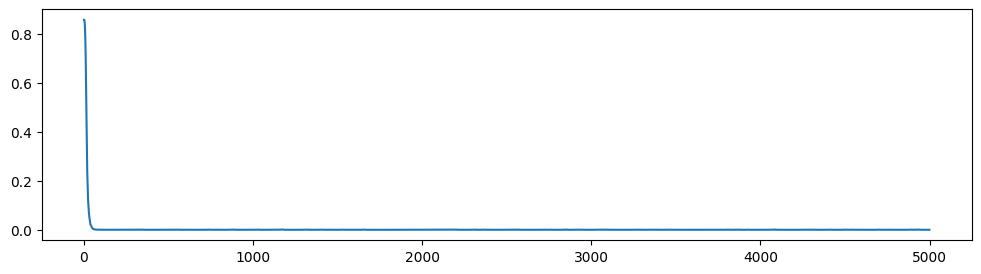

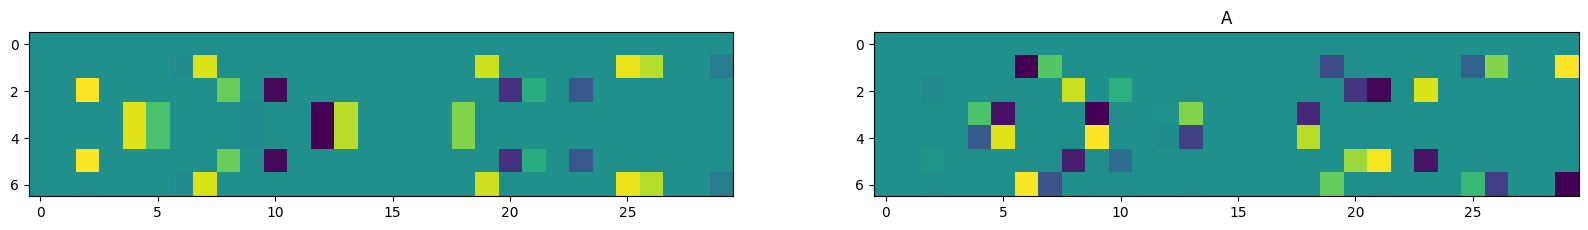

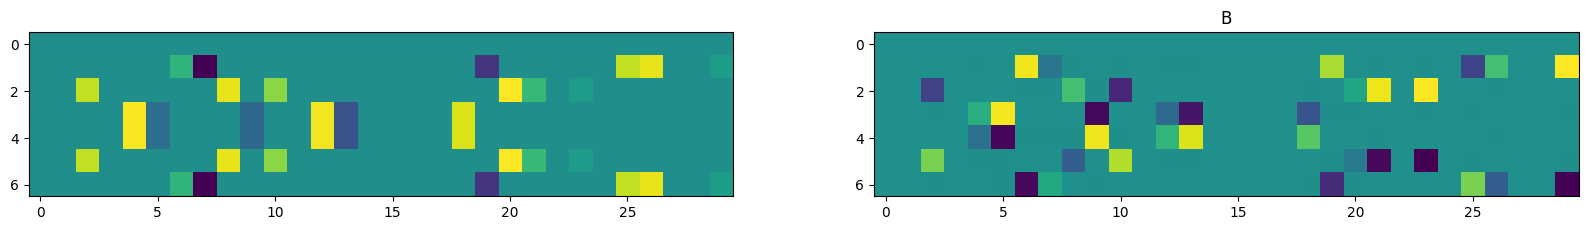

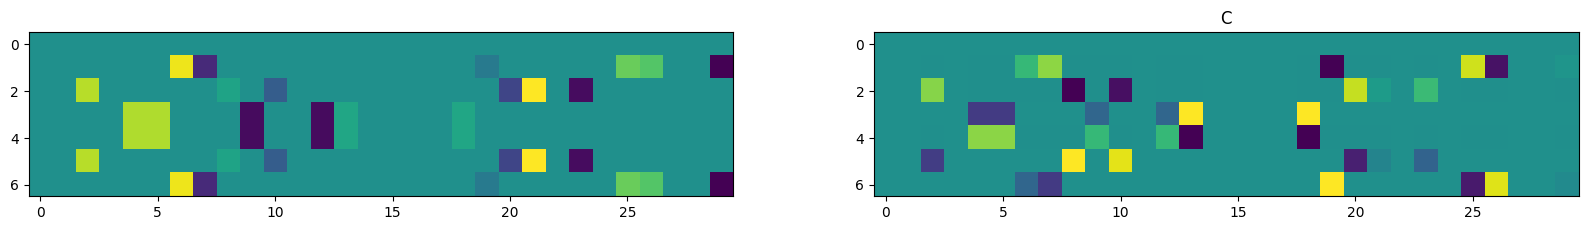

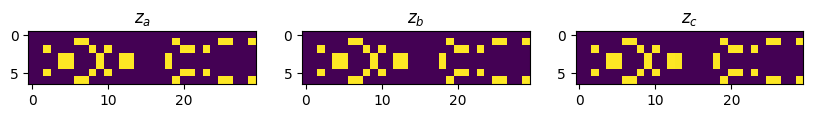

In [304]:
plt.figure(figsize=(12,3))
plt.plot(losses.real)

print(losses[-1].item())
plt.figure(figsize=(20, 30))
plot_complex(A, "A")
plt.figure(figsize=(20, 30))
plot_complex(B, "B")
plt.figure(figsize=(20, 30))
plot_complex(C, "C")

plt.figure(figsize=(10, 30))
plt.subplot(1, 3, 1)
plt.imshow(A.abs())
plt.title("$z_a$")

plt.subplot(1, 3, 2)
plt.imshow(B.abs())
plt.title("$z_b$")

plt.subplot(1, 3, 3)
plt.imshow(C.abs())
plt.title("$z_c$")

plt.savefig("")

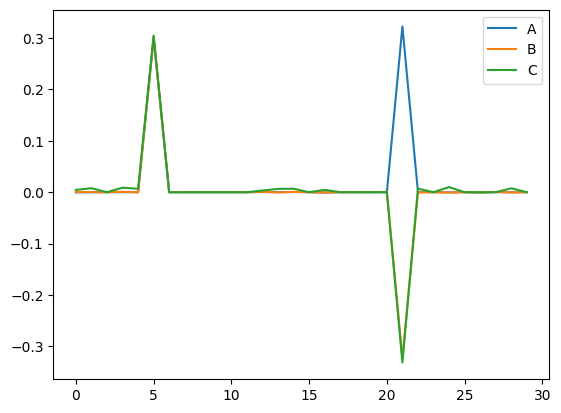

In [282]:
plt.plot(A[4,:].real, label="A")
plt.plot(B[4,:].real, label="B")
plt.plot(C[4,:].real, label="C")

plt.legend()

In [250]:
# All solutions:
print("All solutions")
check_constraints(A, B, C)
print("-----" * 5)

# for each node, get their best freq
best_freqs = A[:(d-1)//2+1].abs().argmax(dim=0).tolist()

for i in range(1, (d-1)//2 + 1):
    indices = [ idx for idx,ii in enumerate(best_freqs) if i == ii ]
    
    print(indices)
    check_constraints(A[:,indices], B[:,indices], C[:,indices])
    print("-----" * 5)

All solutions
ABC Off diagonal
tensor(0.0006)
ABC diagonal
tensor([0.0000+0.0000e+00j, 0.0717+1.8418e-07j, 0.0688+1.5398e-06j,
        0.0718-9.3306e-08j, 0.0718+9.3306e-08j, 0.0688-1.5398e-06j,
        0.0717-1.8418e-07j])
AAC Off diagonal
tensor(0.0456)
AAC diagonal
tensor([ 0.0000e+00+0.0000e+00j,  8.0175e-05+2.1147e-05j,
        -1.1455e-06-3.6005e-06j,  9.0618e-07+4.3828e-06j,
         9.0618e-07-4.3828e-06j, -1.1455e-06+3.6005e-06j,
         8.0175e-05-2.1147e-05j])
BBC Off diagonal
tensor(0.0456)
BBC diagonal
tensor([ 0.0000e+00+0.0000e+00j,  3.6499e-06-5.4155e-05j,
         1.4286e-06+6.9439e-06j, -8.0094e-07+1.9185e-07j,
        -8.0094e-07-1.9185e-07j,  1.4286e-06-6.9439e-06j,
         3.6499e-06+5.4155e-05j])
tensor(0.1152) tensor(0.1149)
-------------------------
[1, 2, 6, 8, 11, 13]
ABC Off diagonal
tensor(3.9426e-05)
ABC diagonal
tensor([ 0.0000e+00+0.0000e+00j,  7.1735e-02+1.8501e-07j,
         4.9422e-09-1.6792e-08j, -2.1303e-11+7.1653e-11j,
        -2.1303e-11-7.1653e-

In [223]:
freq_cnt

tensor([0, 7, 5, 7, 7, 5, 7])

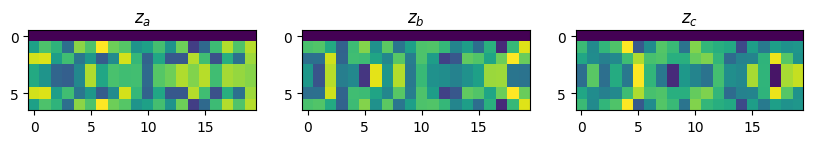

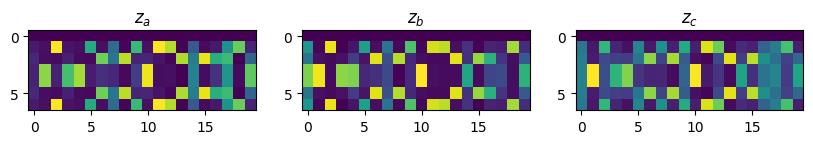

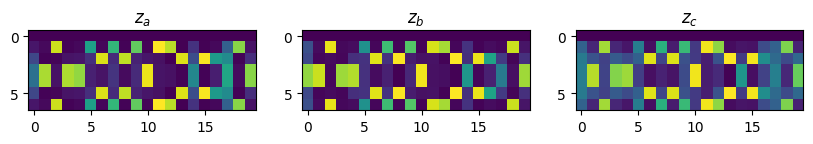

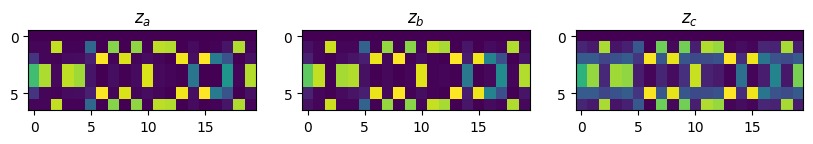

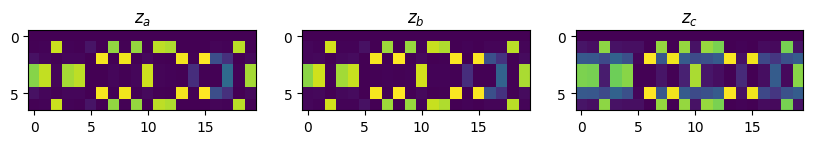

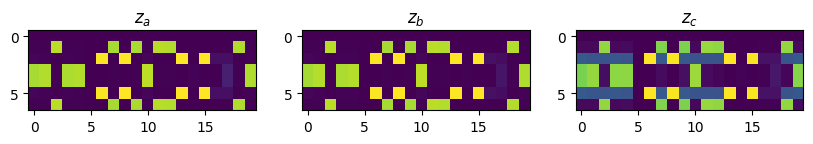

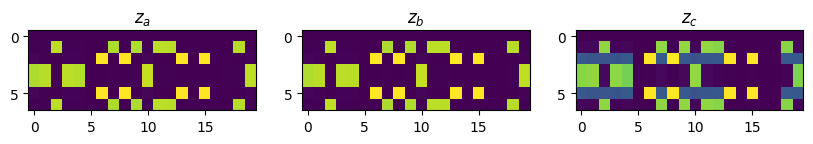

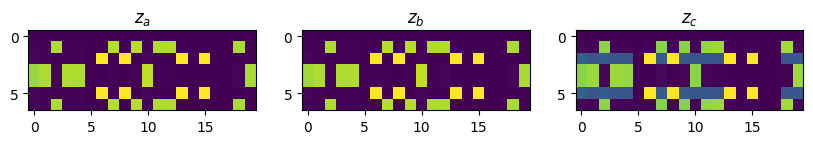

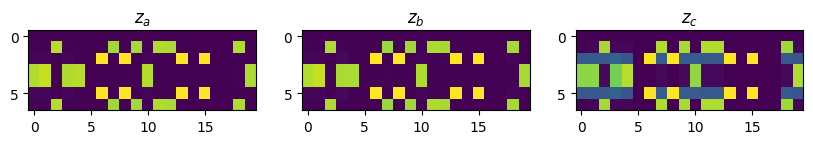

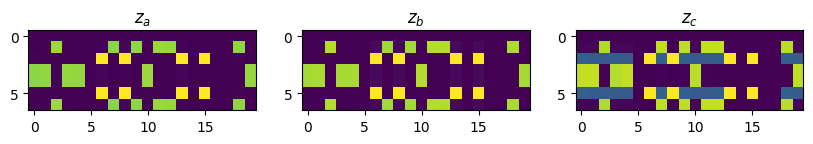

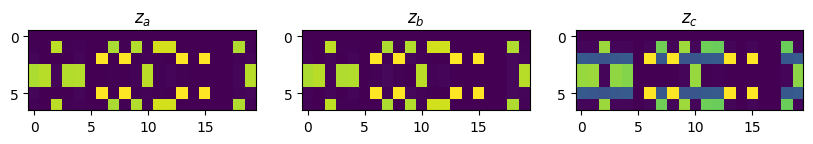

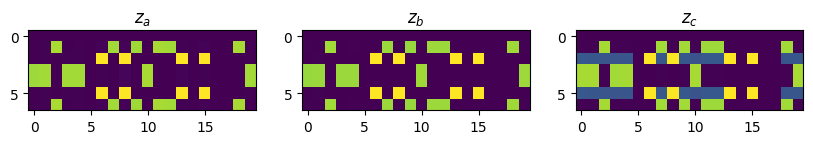

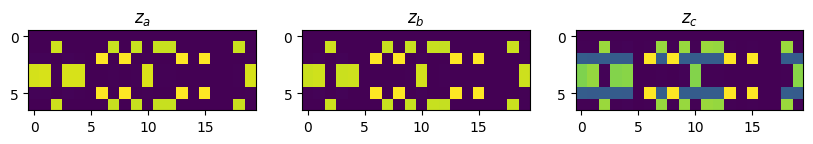

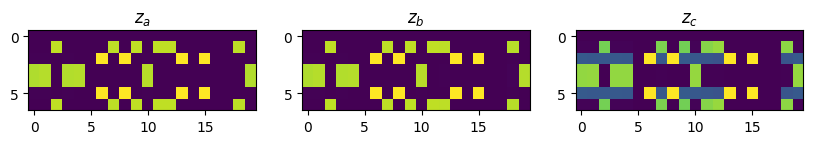

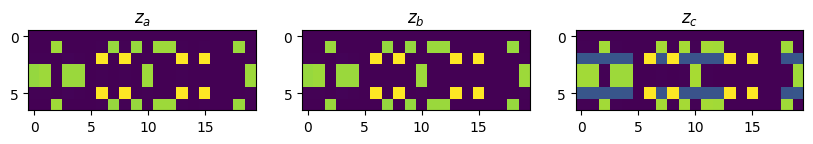

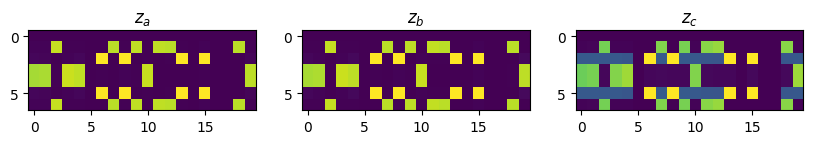

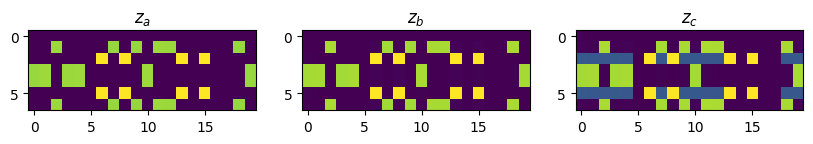

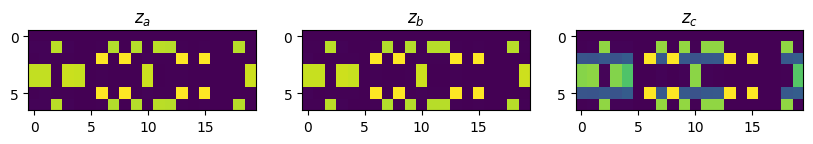

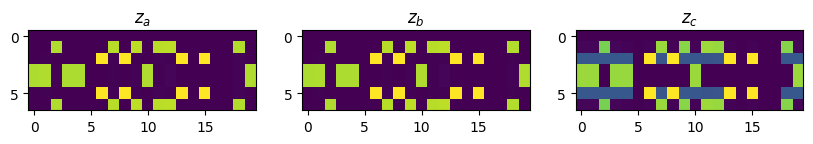

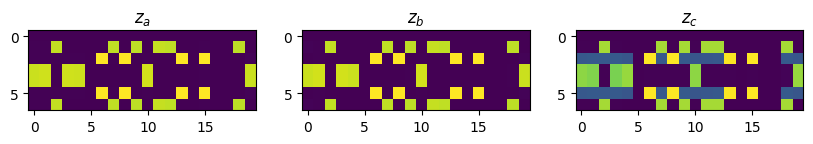

In [172]:
for t in range(len(allA)):
    plt.figure(figsize=(10, 30))
    plt.subplot(1, 3, 1)
    plt.imshow(allA[t].abs())
    plt.title("$z_a$")

    plt.subplot(1, 3, 2)
    plt.imshow(allB[t].abs())
    plt.title("$z_b$")

    plt.subplot(1, 3, 3)
    plt.imshow(allC[t].abs())
    plt.title("$z_c$")

plt.savefig("")

In [137]:
len(allA)

20

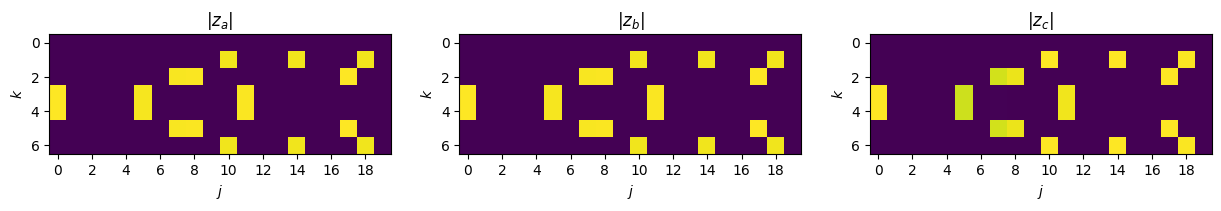

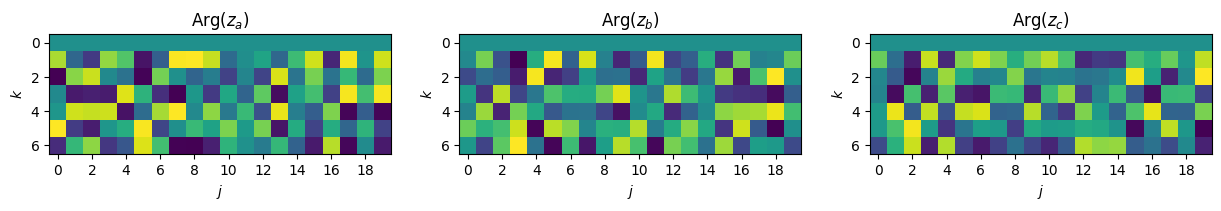

In [135]:
suffix = "3"

plt.figure(figsize=(15, 5))
idx = 1
for name in "ABC":
    plt.subplot(1, 3, idx)
    plt.imshow(eval(name + ".abs()"))
    plt.title(f"$|z_{name.lower()}|$")
    #plt.axis('off')
    plt.xlabel("$j$")
    plt.xticks(range(0, A.shape[1], 2))
    plt.ylabel("$k$")
    plt.yticks(range(0, A.shape[0], 2))
    idx += 1
    
plt.savefig(f"convergence_{suffix}_abs.pdf")

plt.figure(figsize=(15, 5))
idx = 1
for name in "ABC":
    plt.subplot(1, 3, idx)
    plt.imshow(eval(name + ".angle()"))
    plt.title(rf"$\mathrm{{Arg}}(z_{name.lower()})$")
    #plt.axis('off')
    plt.xlabel("$j$")
    plt.xticks(range(0, A.shape[1], 2))
    plt.ylabel("$k$")
    plt.yticks(range(0, A.shape[0], 2))
    idx += 1

plt.savefig(f"convergence_{suffix}_arg.pdf")

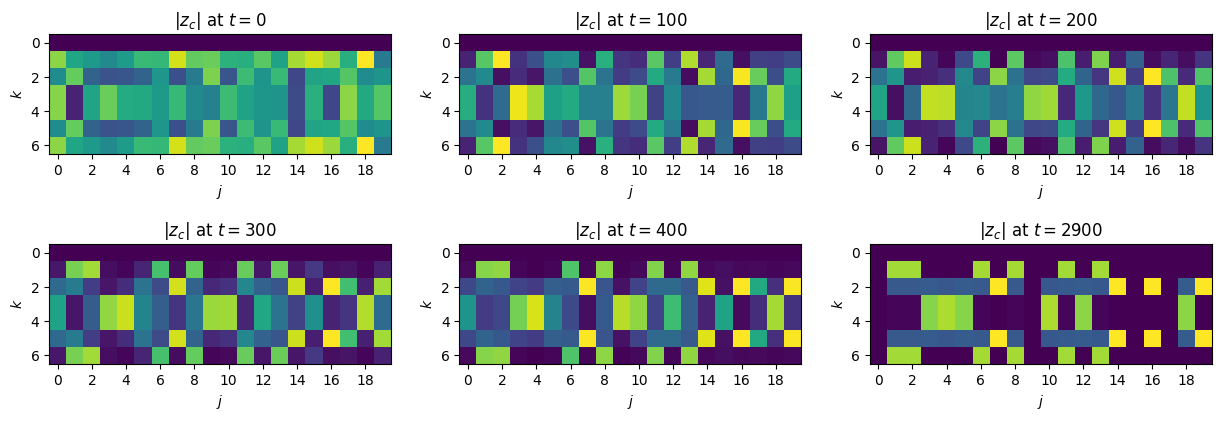

In [251]:
plt.figure(figsize=(15, 5))

for i, t in enumerate([0,1,2,3,4,-1]):
    plt.subplot(2, 3, i + 1)
    C = allC[t]
    plt.imshow(C.abs())
    plt.title(f"$|z_c|$ at $t = {allts[t]}$")
    plt.xlabel("$j$")
    plt.xticks(range(0, C.shape[1], 2))
    plt.ylabel("$k$")
    plt.yticks(range(0, C.shape[0], 2))

plt.savefig(f"convergence_path.pdf")

In [72]:
def show_angle(a):
    angle = a / math.pi + 1
    angle[angle > 1] -= 1    
    print(angle * 180)

for row in range(1, d//2 + 1):
    print(f"Row {row}")
    # find nonzero columns
    cols = ((A[row,:] * B[row,:] * C[row,:]).abs() > 1e-3).nonzero().squeeze()

    a = A[row,cols]
    b = B[row,cols]
    c = C[row,cols]
    abc = a * b * c

    # A*B*C
    print("A", a, "sum(A)", a.sum())
    print("B", b, "sum(B)", b.sum())
    print("A*B", a*b, "sum(A*B)", (a*b).sum())
    print("C", c, "sum(C)", c.sum())
    
    print("A*B*C", abc)
    print("sum(A*B*C)", abc.sum())
    # Compute their relative angles.
    print((abc[0] * abc[1].conj()).angle() / math.pi * 180)
    print((abc[1] * abc[2].conj()).angle() / math.pi * 180)
    print((abc[0] * abc[2].conj()).angle() / math.pi * 180)
    
    a_bconj = a * b.conj()
    b_cconj = b * c.conj()
    c_aconj = c * a.conj()
    
    # Check whether they have the same angle.
    show_angle(a_bconj.angle())
    show_angle(b_cconj.angle())
    show_angle(c_aconj.angle())

    print(abc.abs())


Row 1
A tensor([ 0.0260-0.2262j, -0.2074+0.0914j,  0.1814+0.1366j,  0.0256-0.2259j,
         0.2101-0.0924j, -0.1837-0.1382j]) sum(A) tensor(0.0522-0.4547j)
B tensor([-0.1570+0.1645j,  0.2187+0.0518j,  0.0616+0.2160j,  0.1565-0.1644j,
         0.2214+0.0527j,  0.0624+0.2186j]) sum(B) tensor(0.5635+0.5391j)
A*B tensor([ 0.0331+0.0398j, -0.0501+0.0092j, -0.0183+0.0476j, -0.0331-0.0396j,
         0.0514-0.0094j,  0.0187-0.0488j]) sum(A*B) tensor(0.0017-0.0011j)
C tensor([ 0.1481-0.1767j, -0.2240-0.0366j, -0.0767-0.2140j, -0.1460+0.1781j,
         0.2260+0.0376j,  0.0783+0.2155j]) sum(C) tensor(0.0057+0.0039j)
A*B*C tensor([0.0119+4.4394e-05j, 0.0116-2.3524e-04j, 0.0116+2.7446e-04j,
        0.0119-1.1903e-04j, 0.0120-1.8633e-04j, 0.0120+2.2196e-04j])
sum(A*B*C) tensor(0.0709+2.1247e-07j)
tensor(1.3791)
tensor(-2.5224)
tensor(-1.1433)
tensor([142.8908, 142.8874, 142.8895, 142.8849, 142.8827, 142.8932])
tensor([3.7071, 4.0623, 3.8156, 4.2345, 3.9472, 4.0300])
tensor([33.4021, 33.0504, 33.294

In [174]:
cols

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [81]:
def check_hemi(A):
    A_chop = A[1:,:]
    avg = A_chop + A_chop.flip(dims=[0])
    real_norm = avg.real.norm()
    imag_norm = avg.imag.norm()
    imag_ratio = imag_norm / math.sqrt(real_norm**2 + imag_norm**2)
    print(imag_ratio)

def keep_hemi(A):
    A[1:,:] = (A[1:,:] + A[1:,:].flip(dims=[0]).conj()) / 2

def plot_complex(M, title):
    plt.subplot(1, 2, 1)
    plt.imshow(M.real)
    plt.subplot(1, 2, 2)
    plt.imshow(M.imag)
    plt.title(title)
    plt.show()


0 tensor(-0.0108) tensor(0.4166) tensor(0.3223) tensor(0.4045)


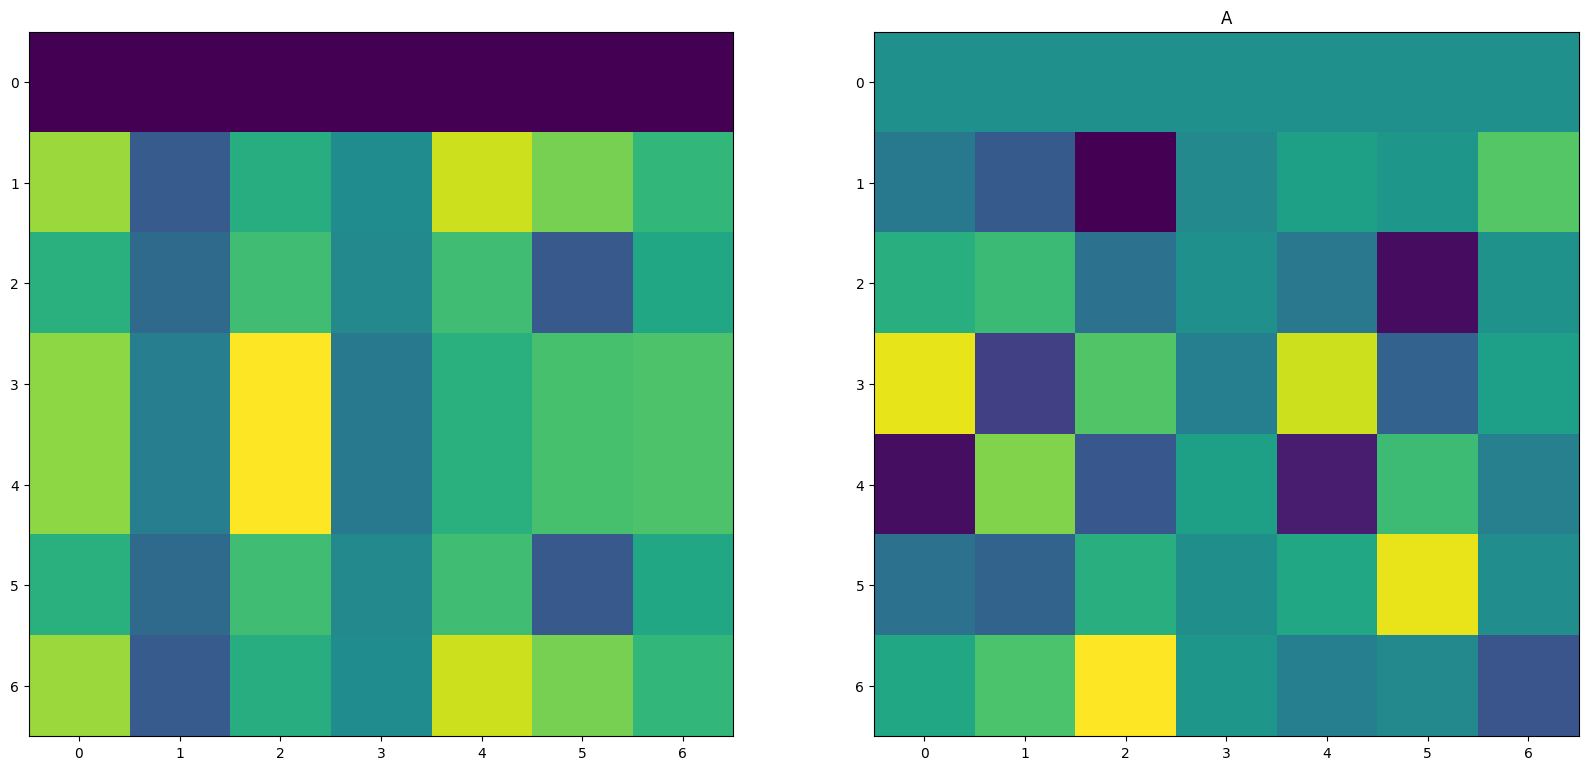

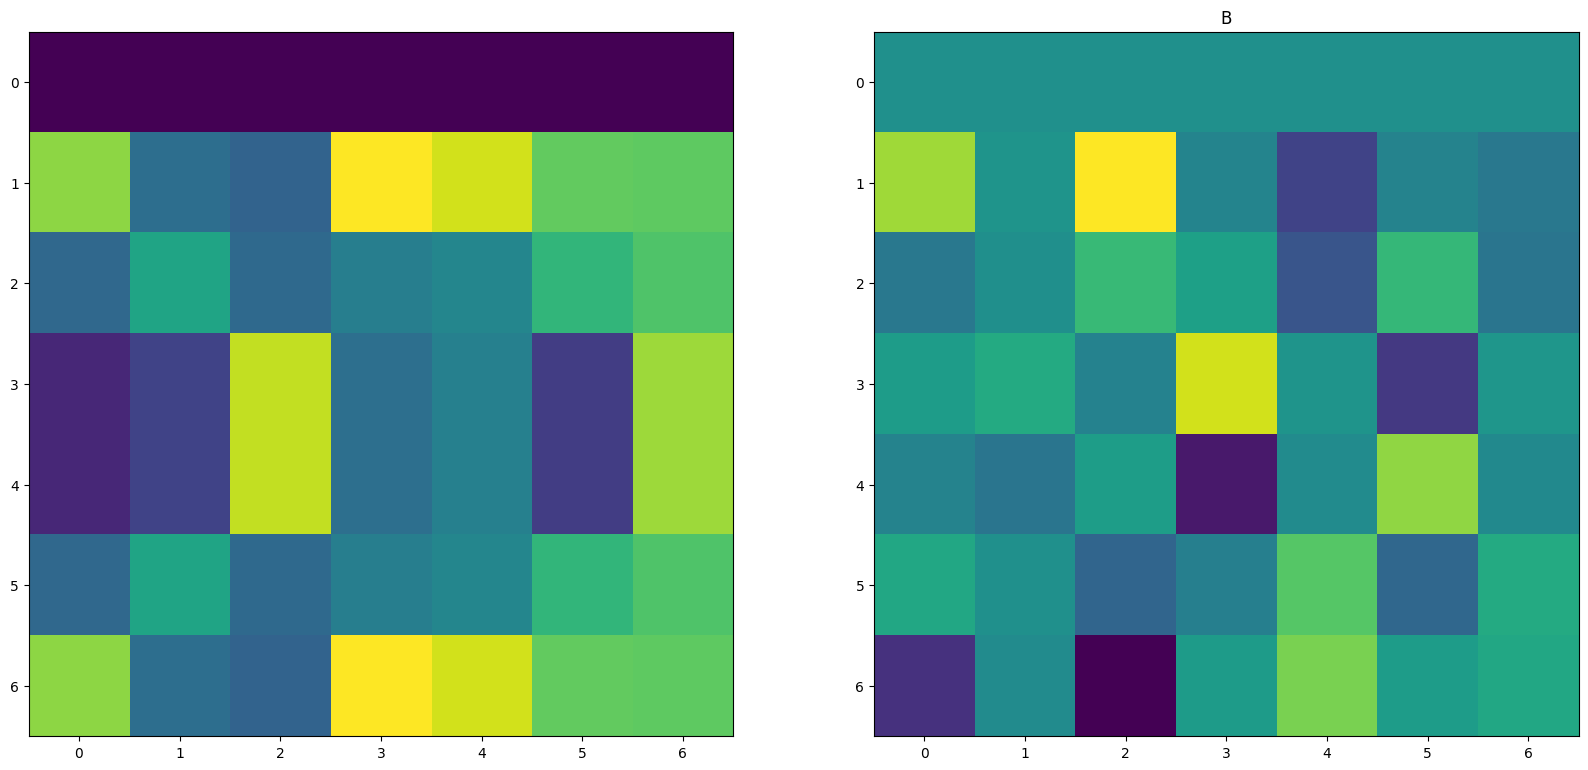

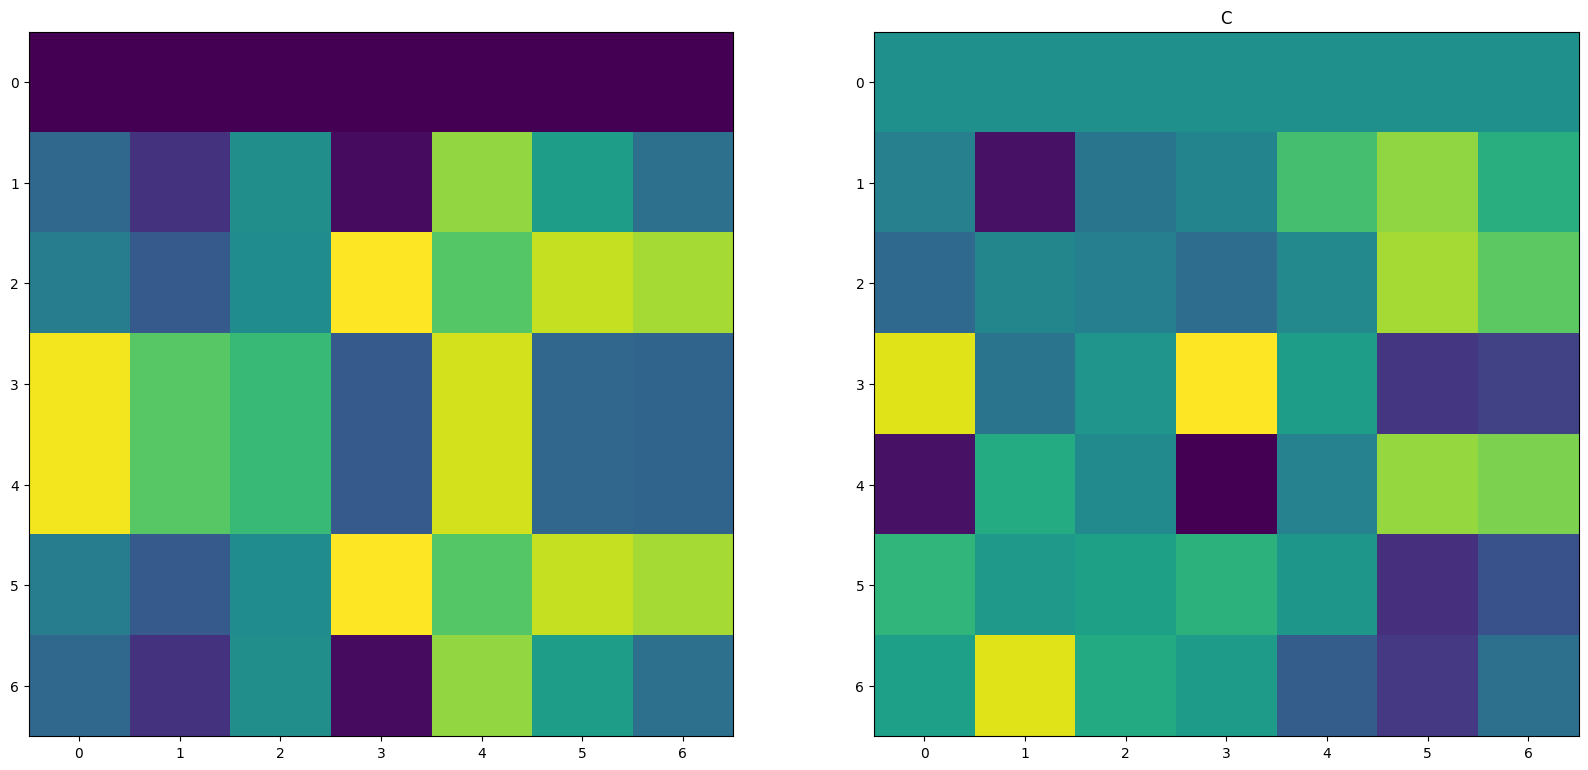

8 tensor(-4.5000) tensor(2.7004) tensor(2.6889) tensor(2.6966)


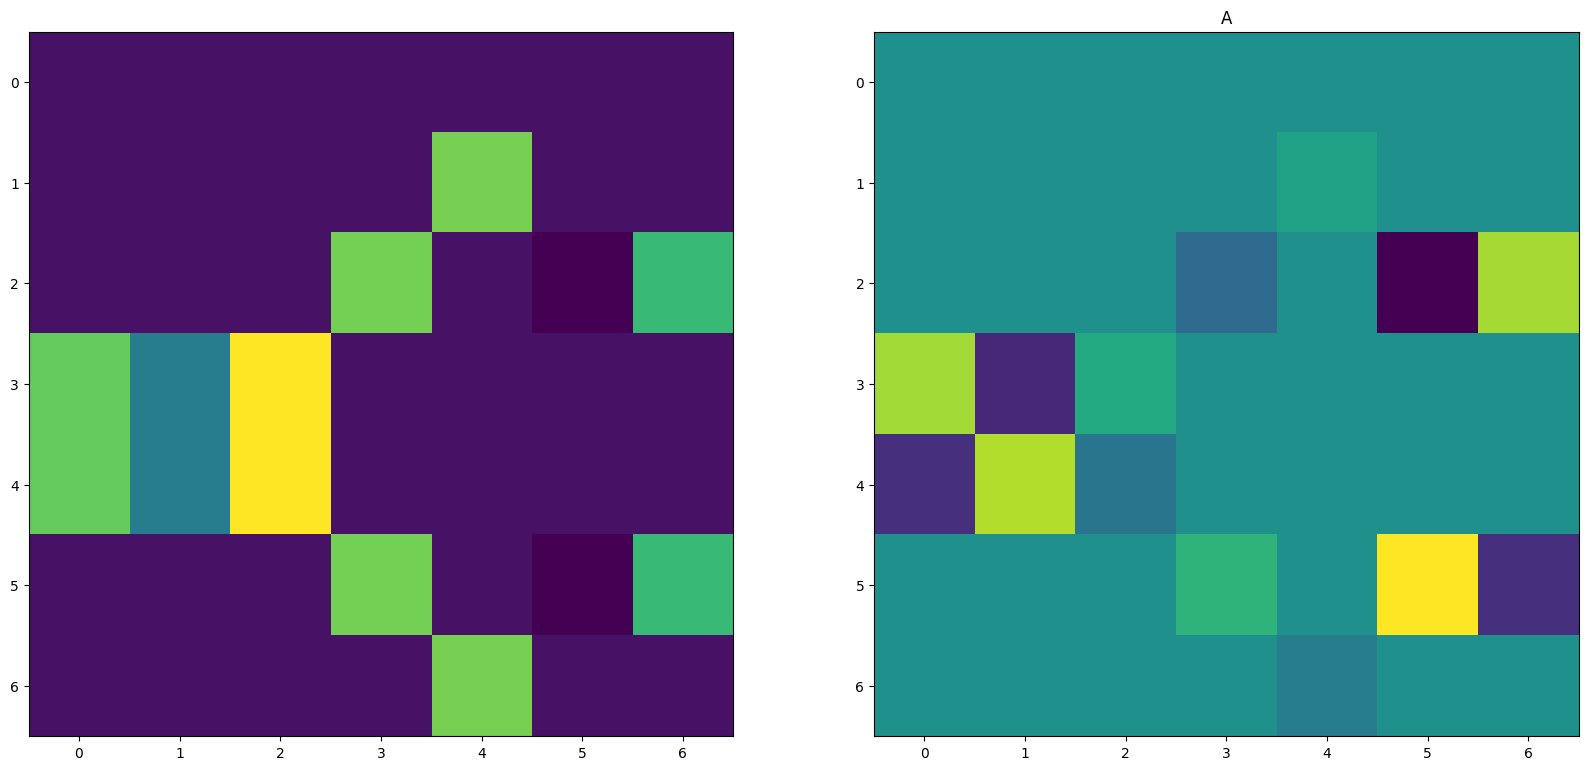

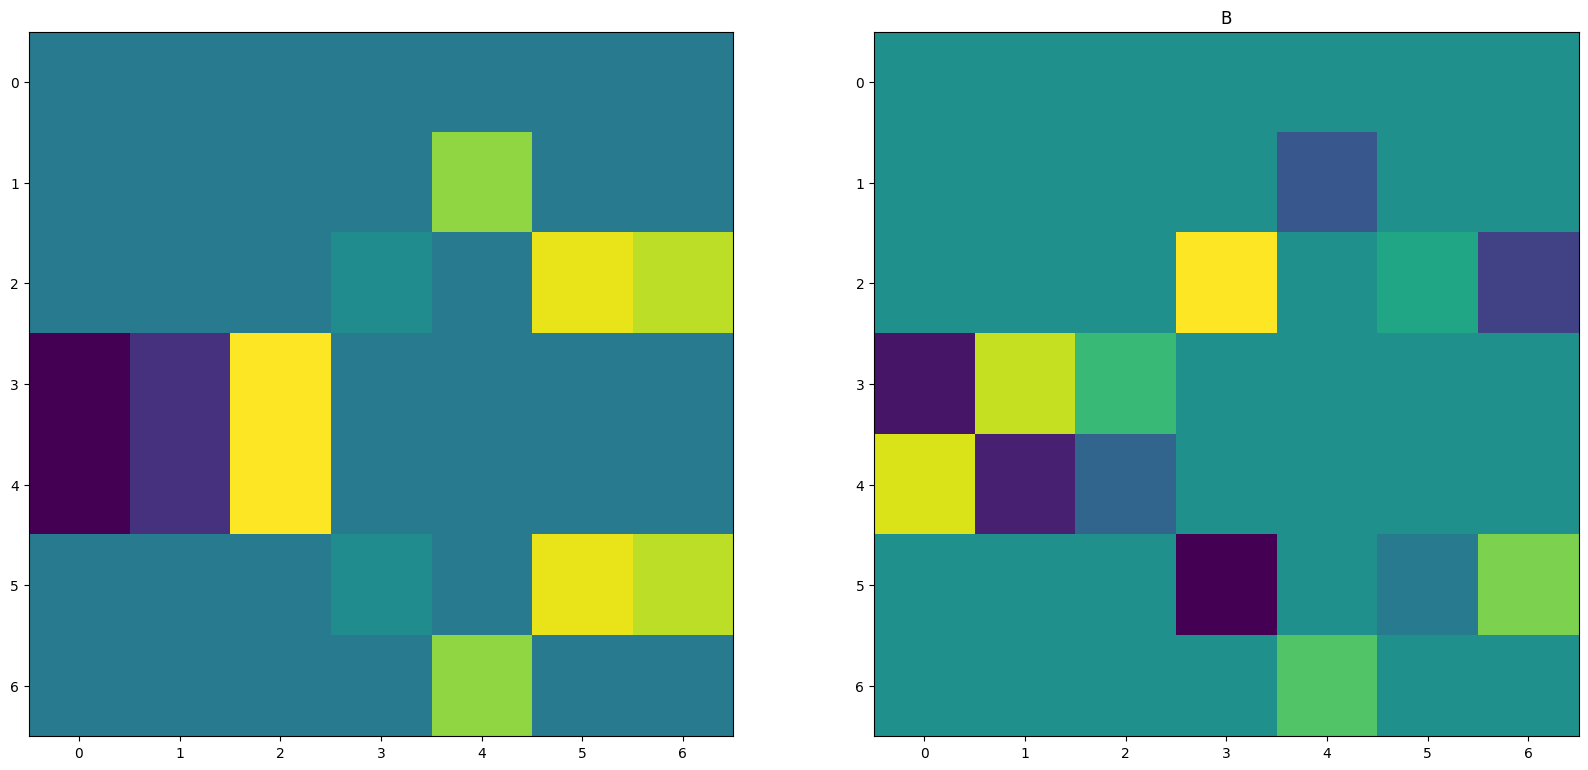

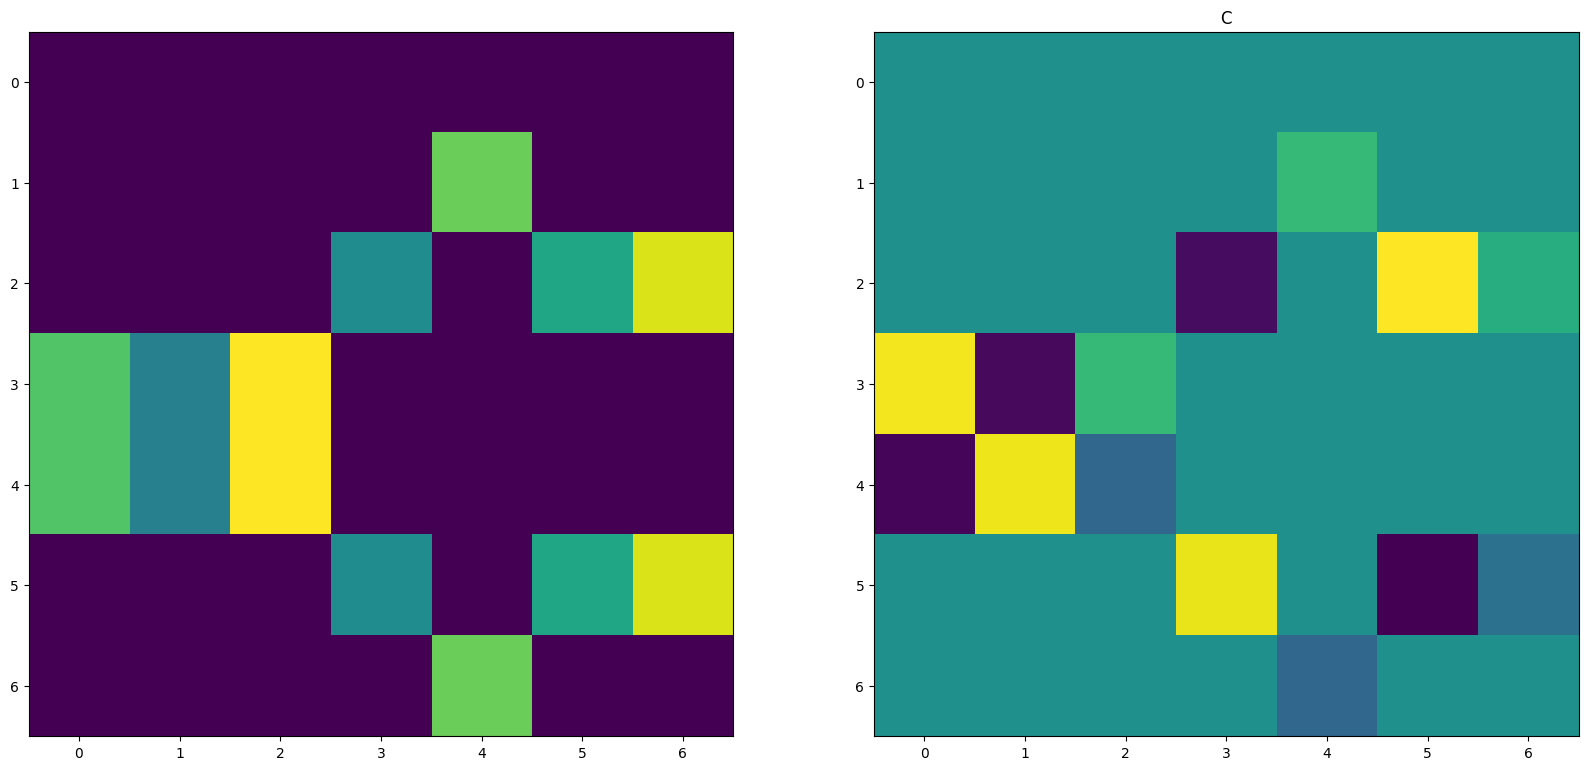

9 tensor(-4.5000) tensor(2.7003) tensor(2.6889) tensor(2.6966)


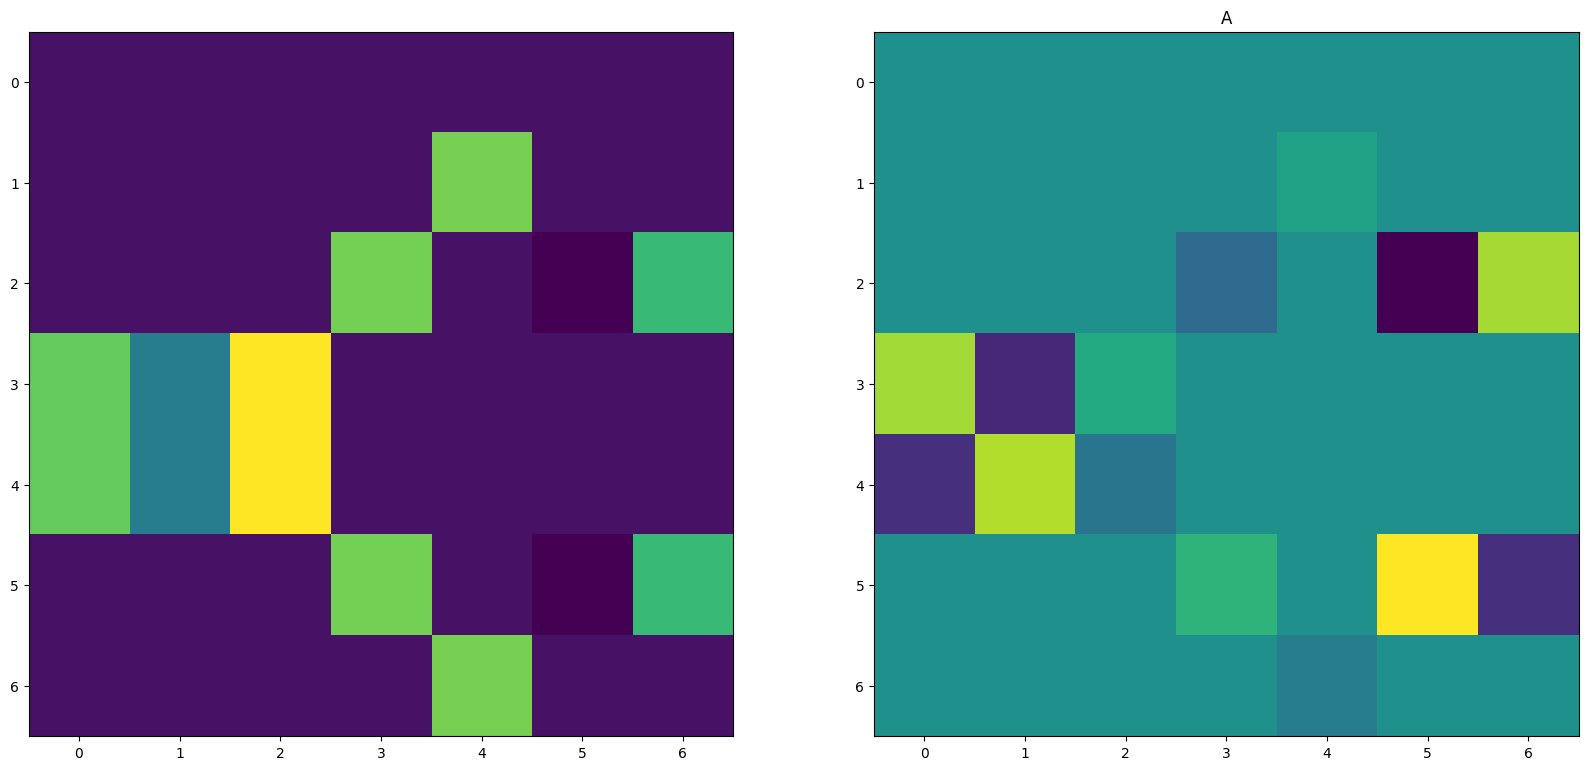

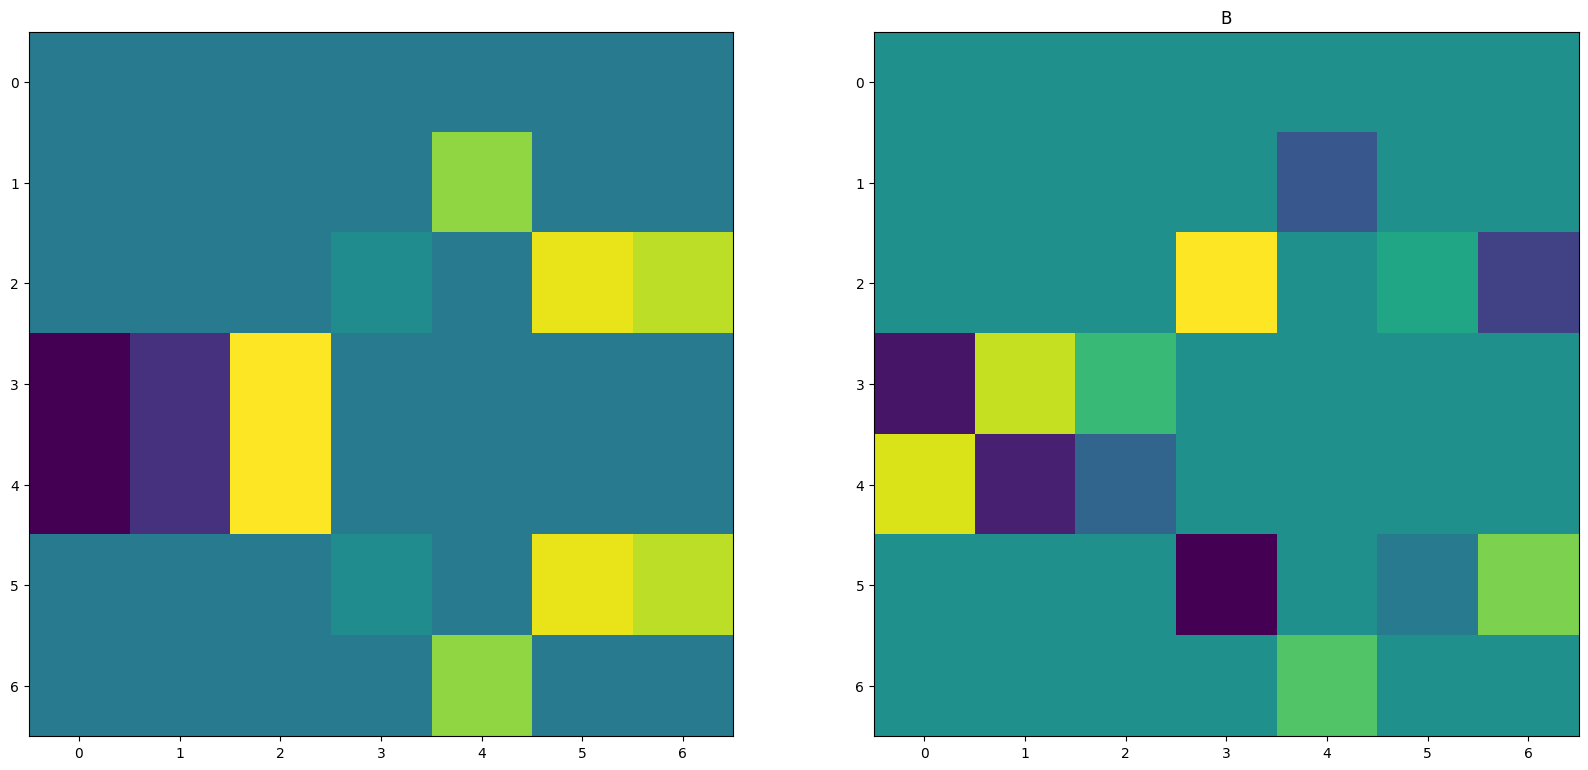

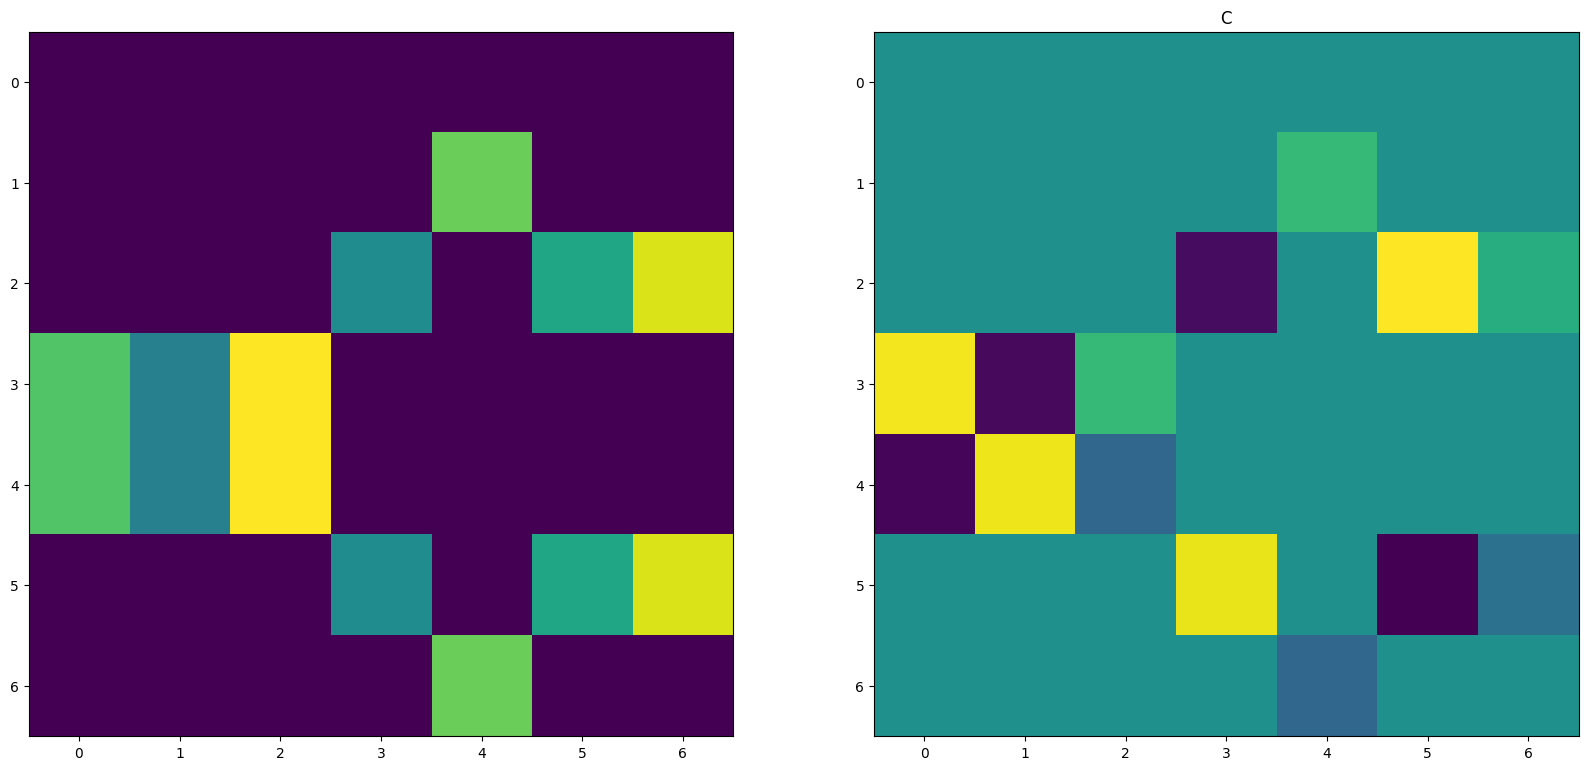

10 tensor(-4.5000) tensor(2.7003) tensor(2.6889) tensor(2.6965)


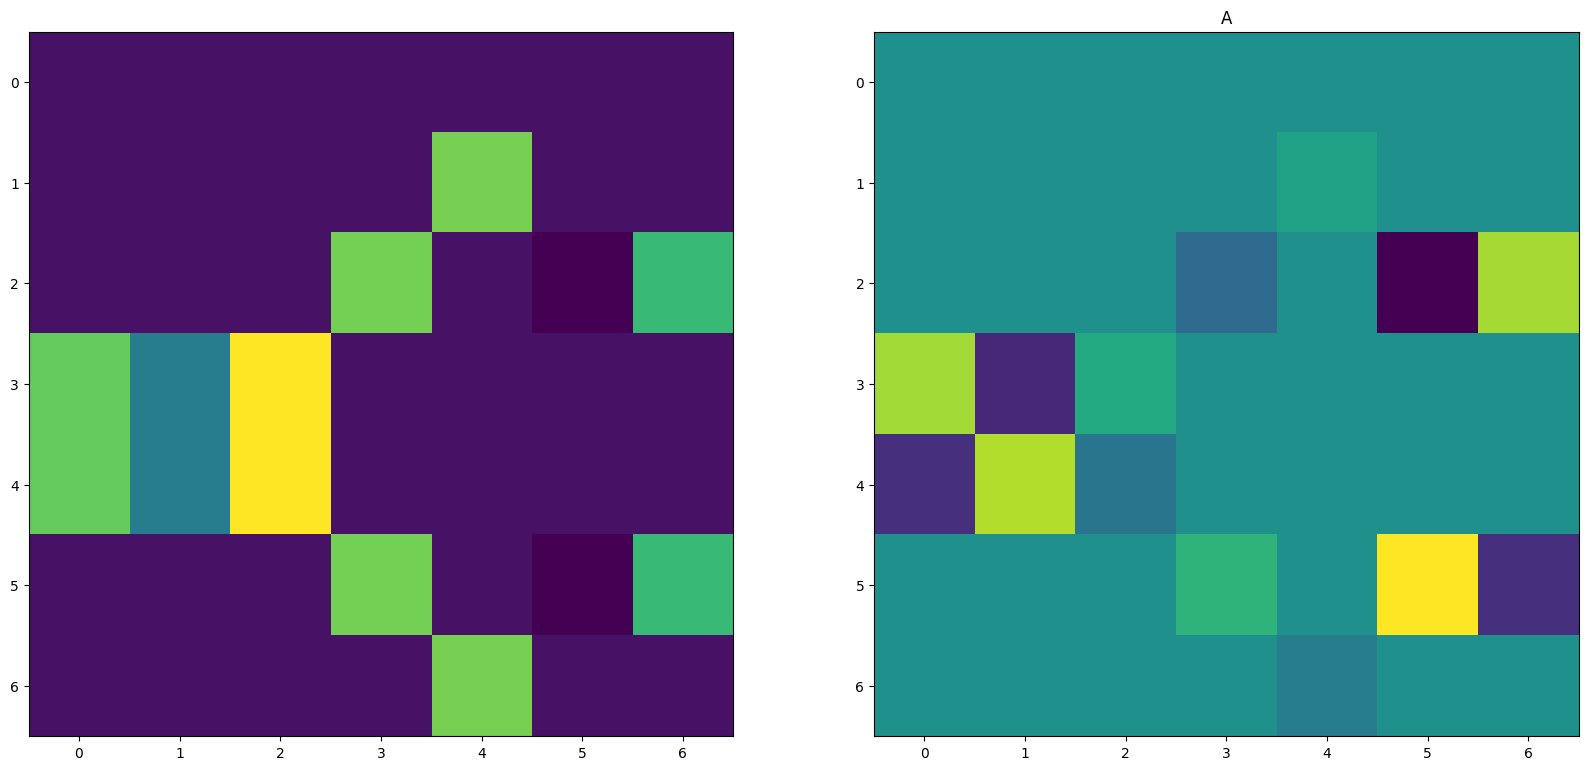

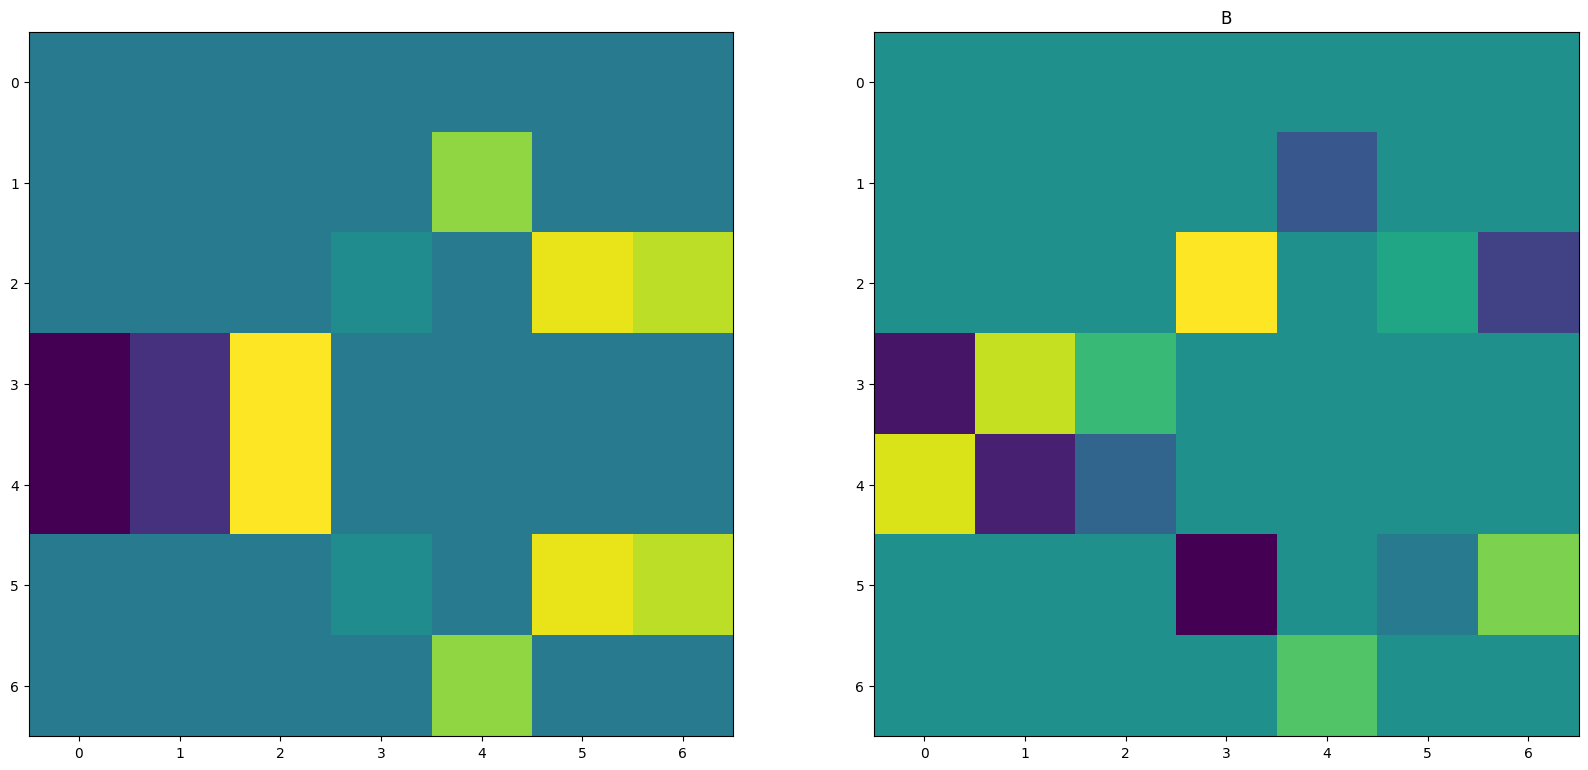

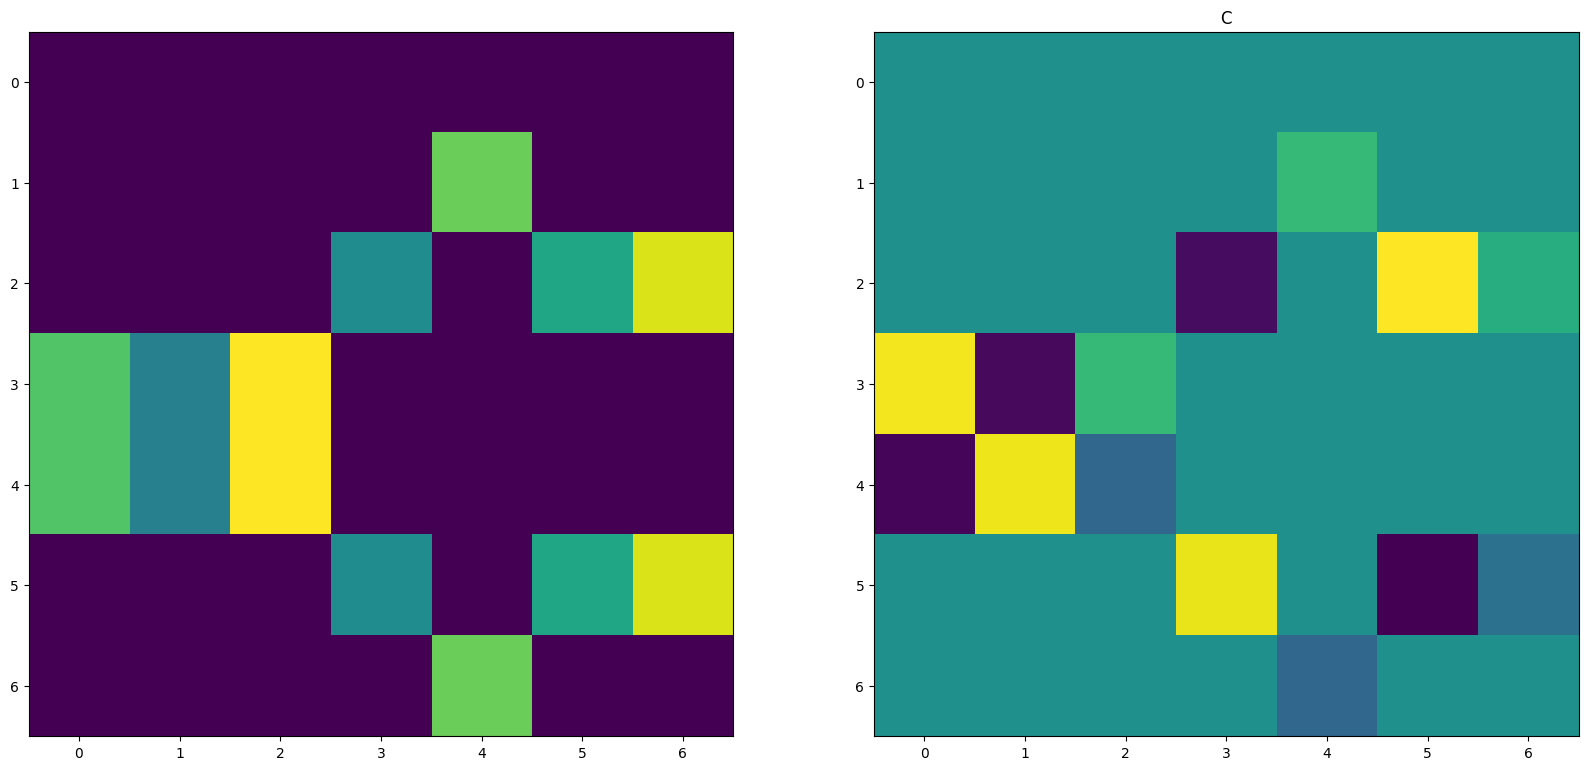

11 tensor(-4.5000) tensor(2.7003) tensor(2.6888) tensor(2.6965)


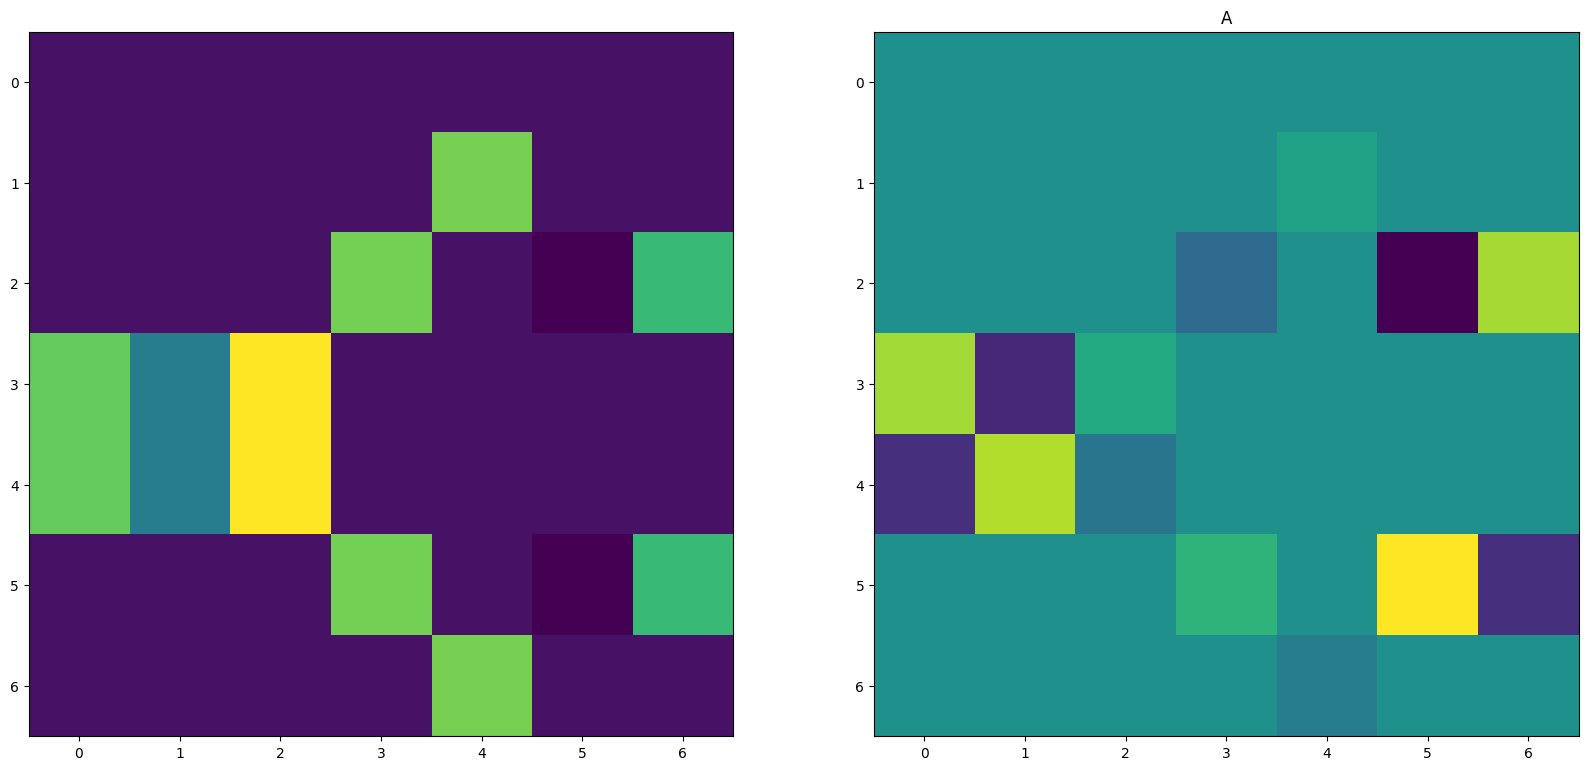

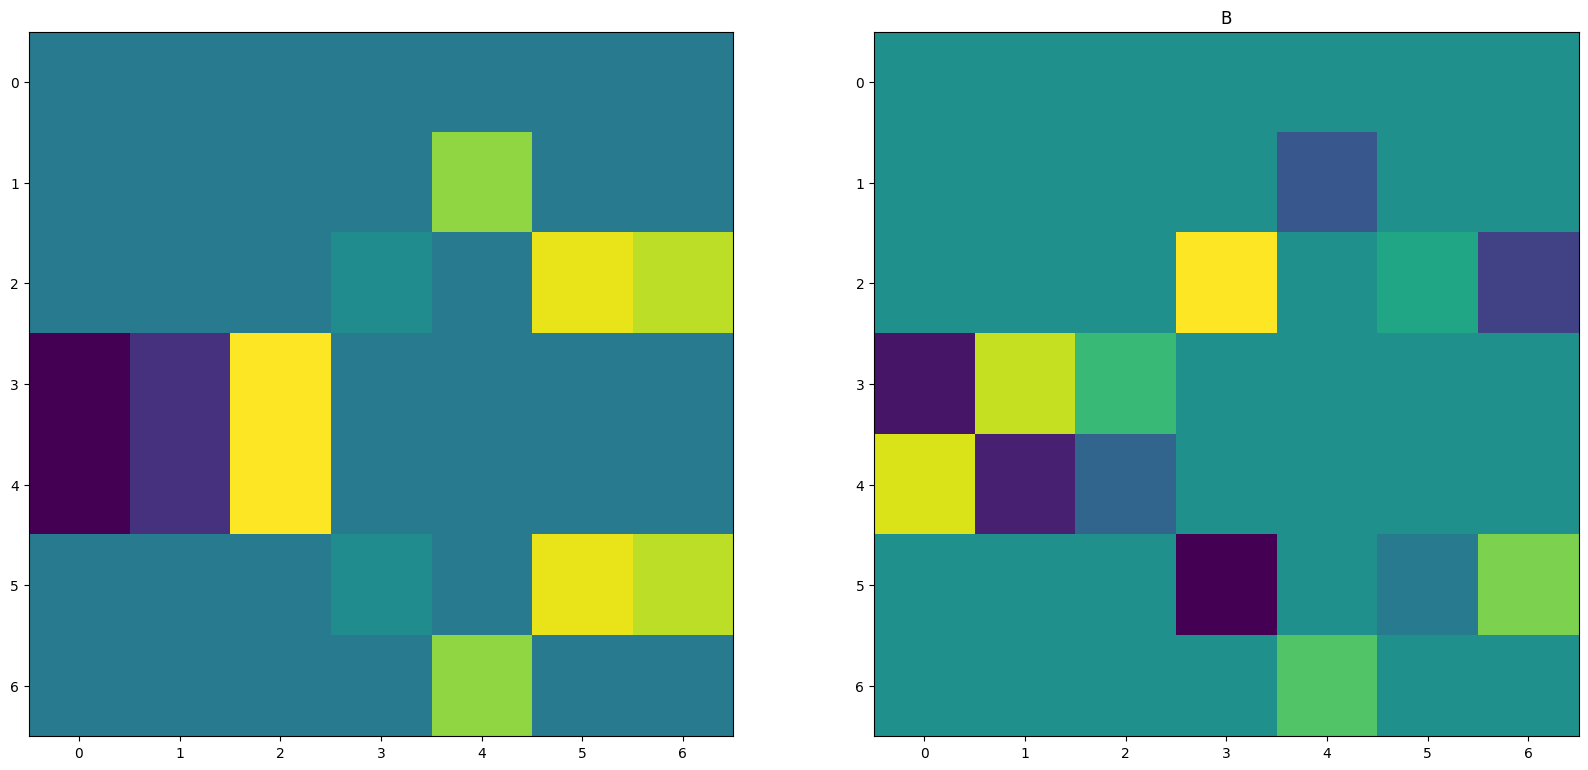

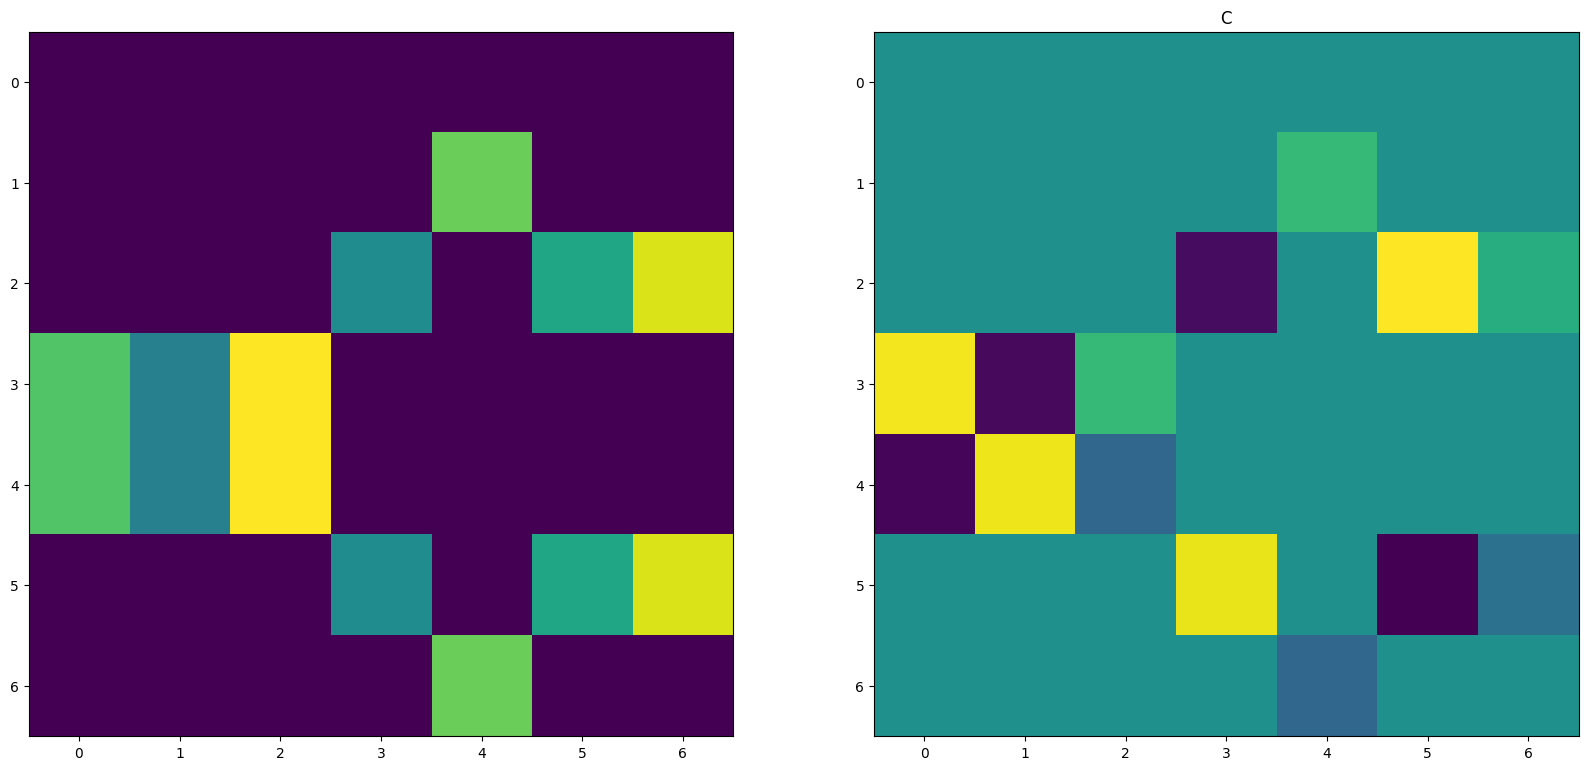

12 tensor(-4.5000) tensor(2.7002) tensor(2.6888) tensor(2.6965)


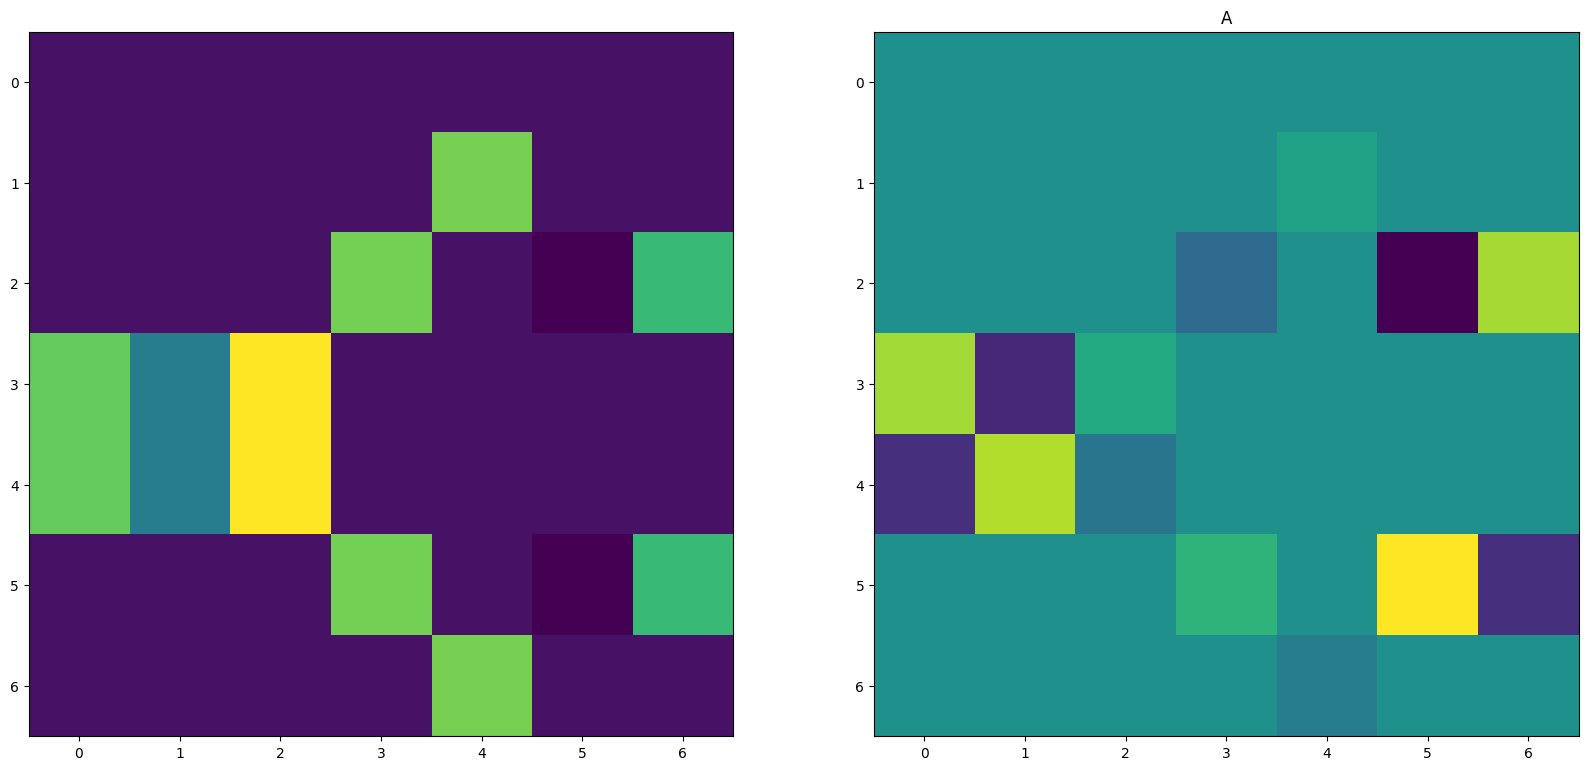

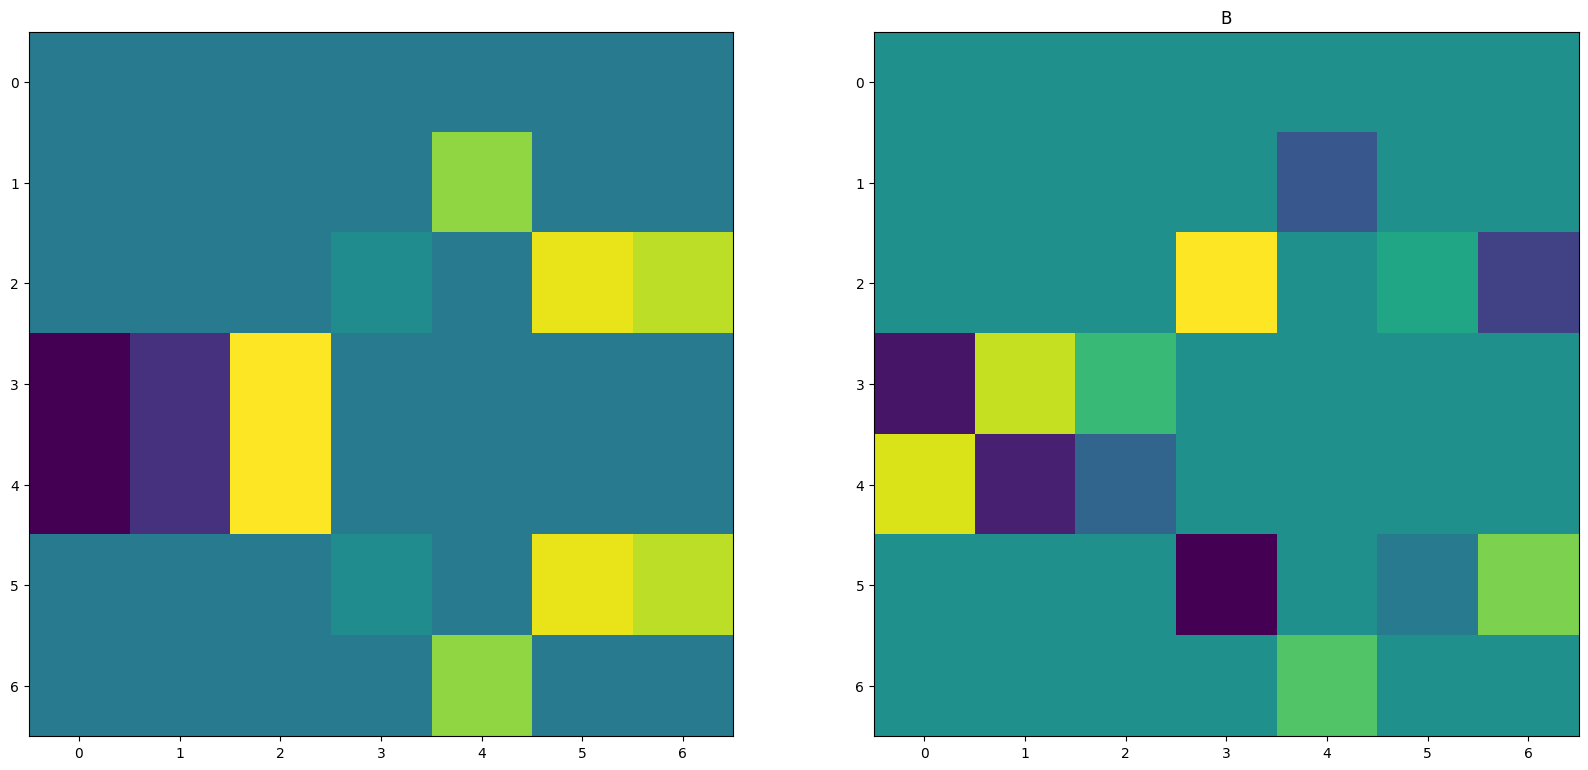

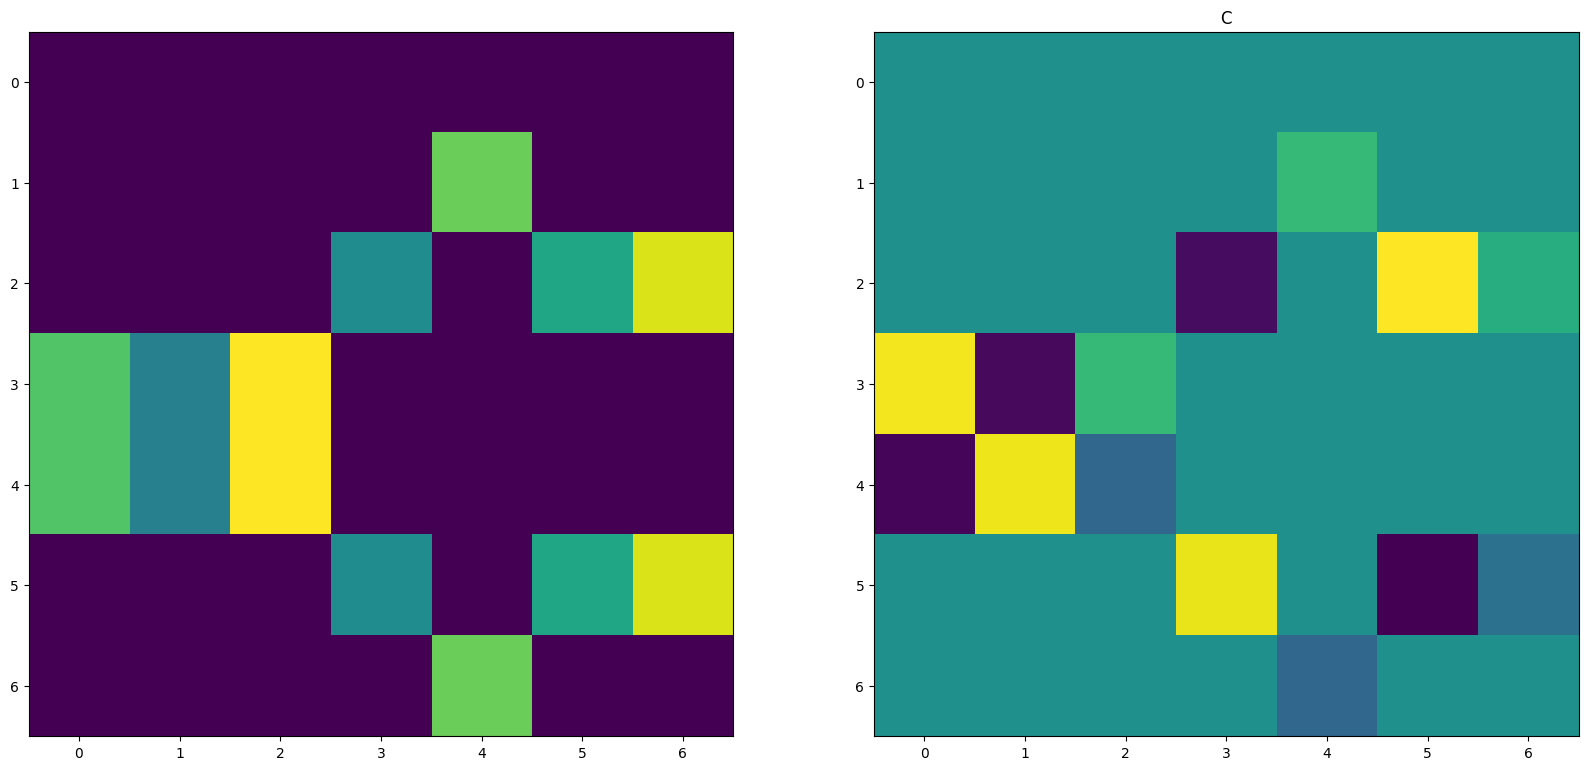

13 tensor(-4.5000) tensor(2.7002) tensor(2.6888) tensor(2.6964)


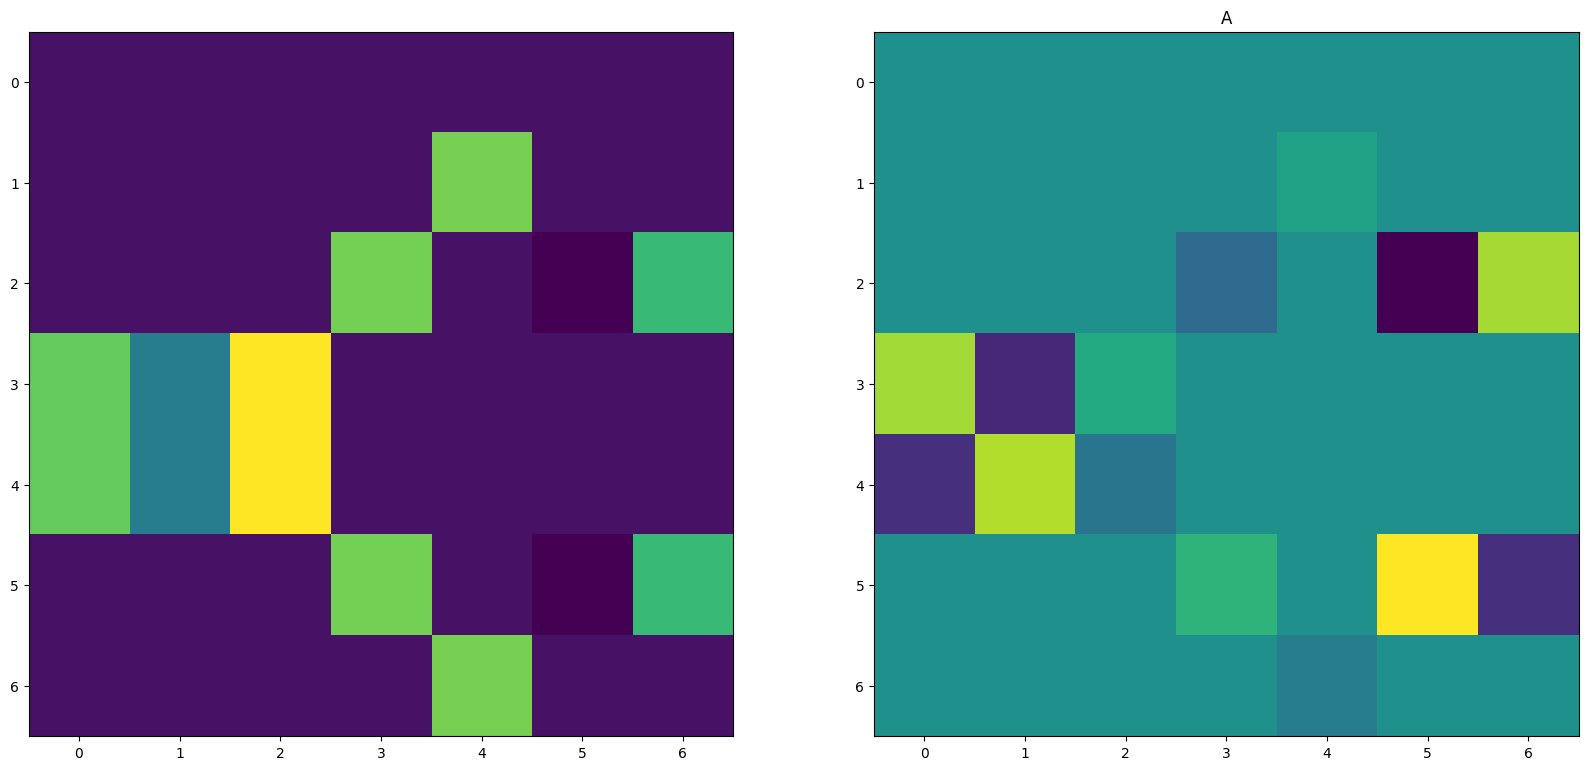

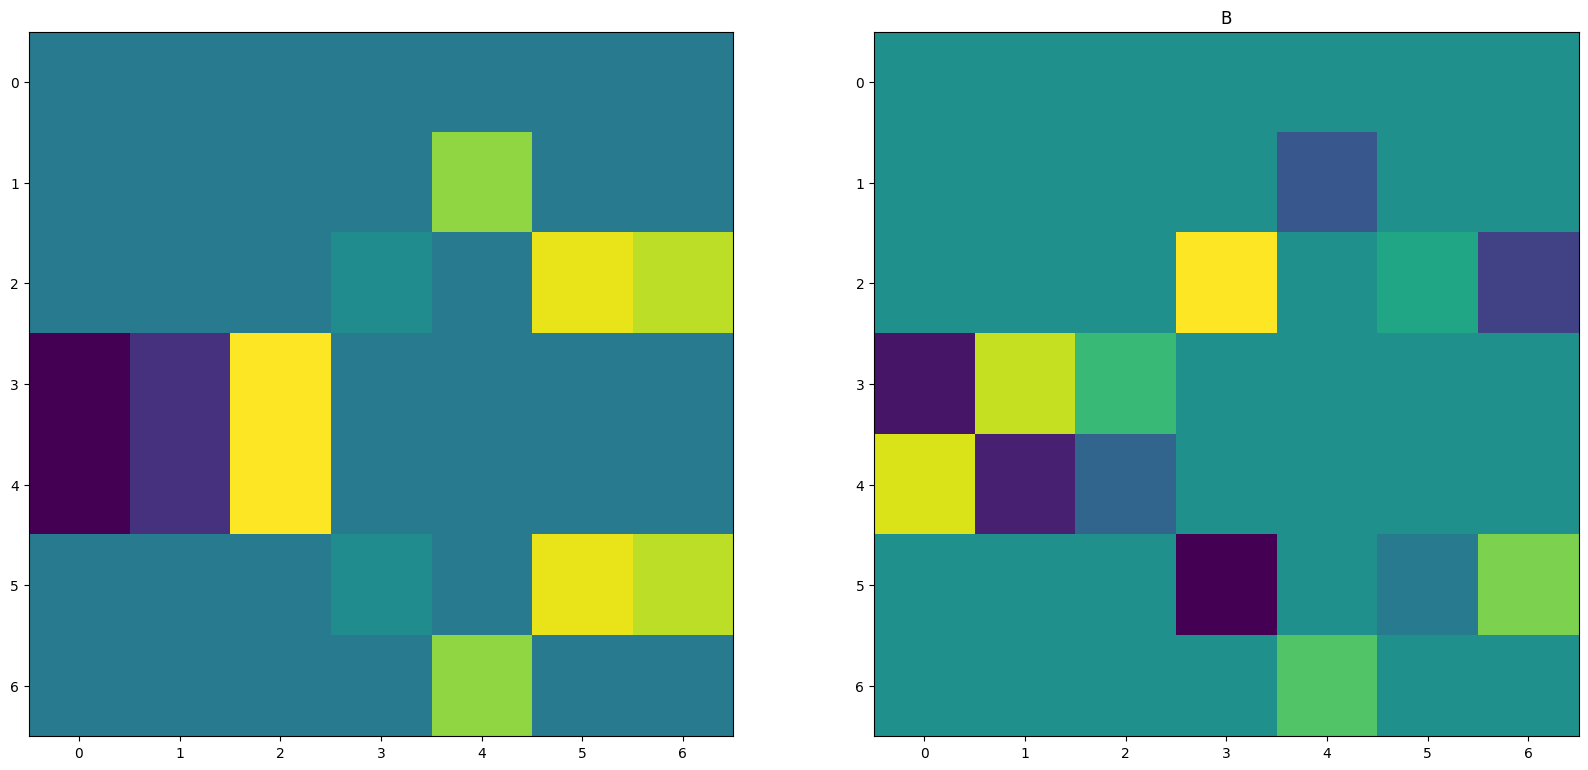

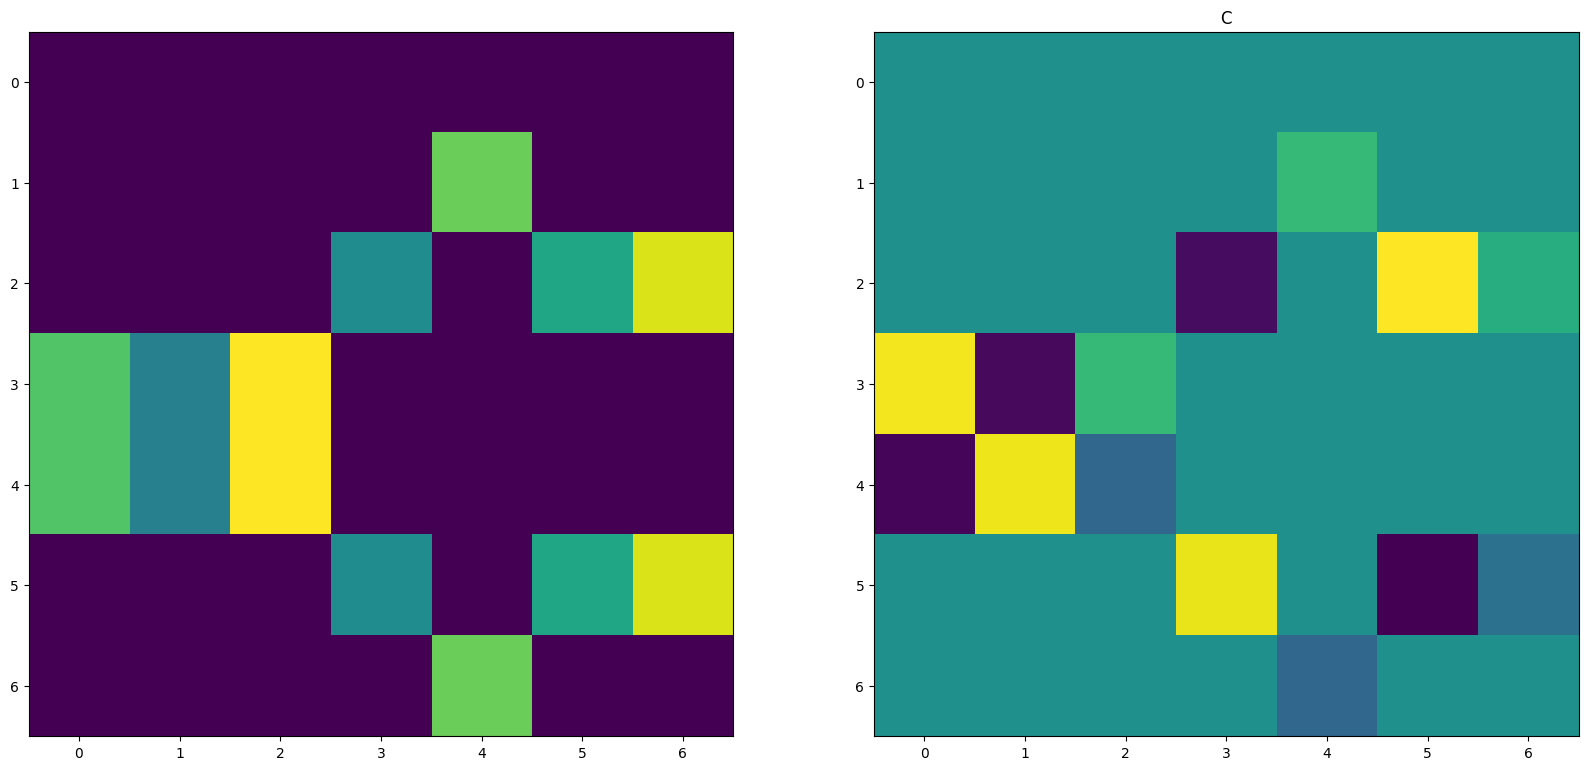

14 tensor(-4.5000) tensor(2.7002) tensor(2.6887) tensor(2.6964)


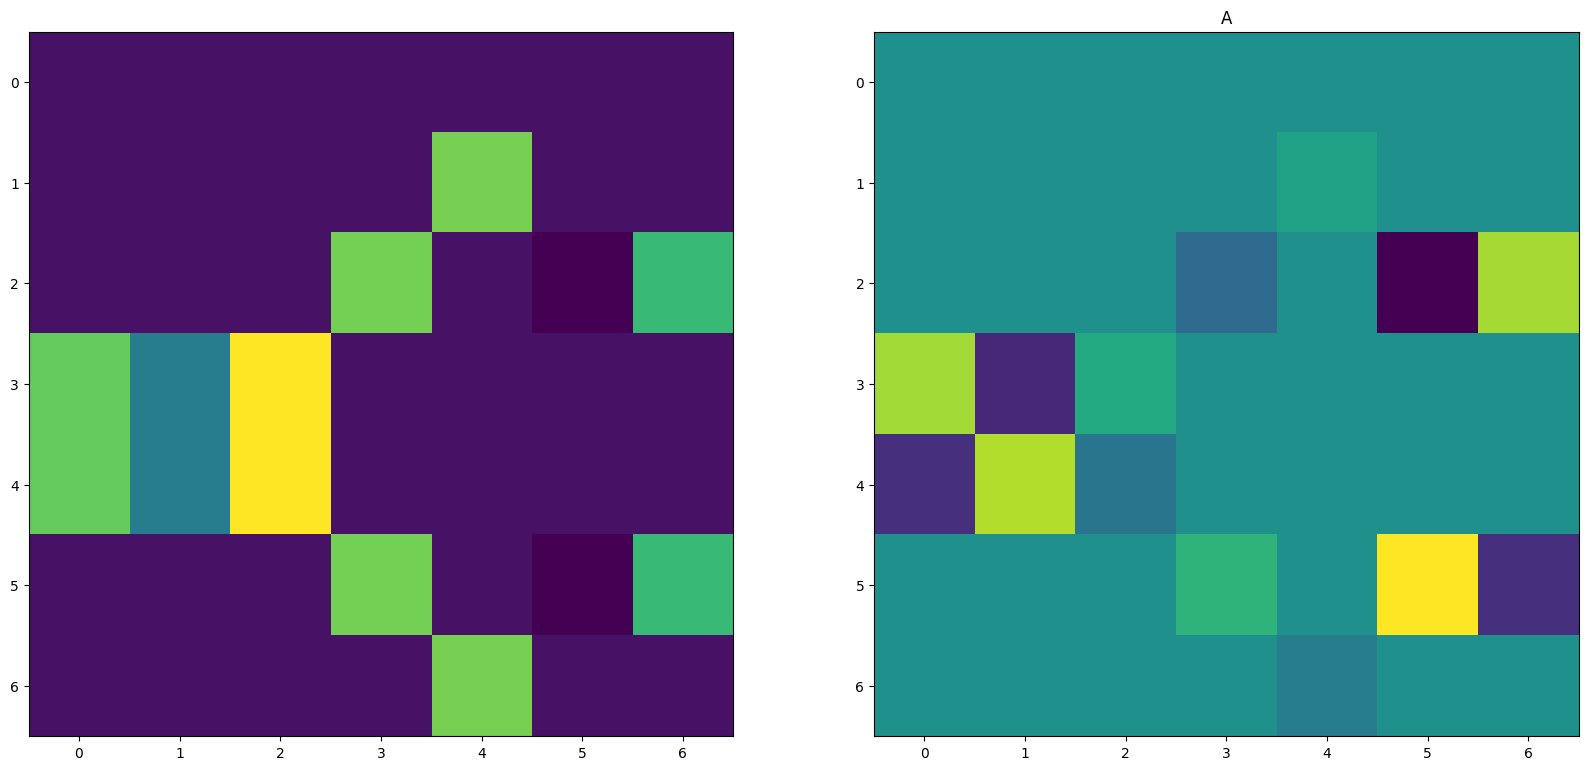

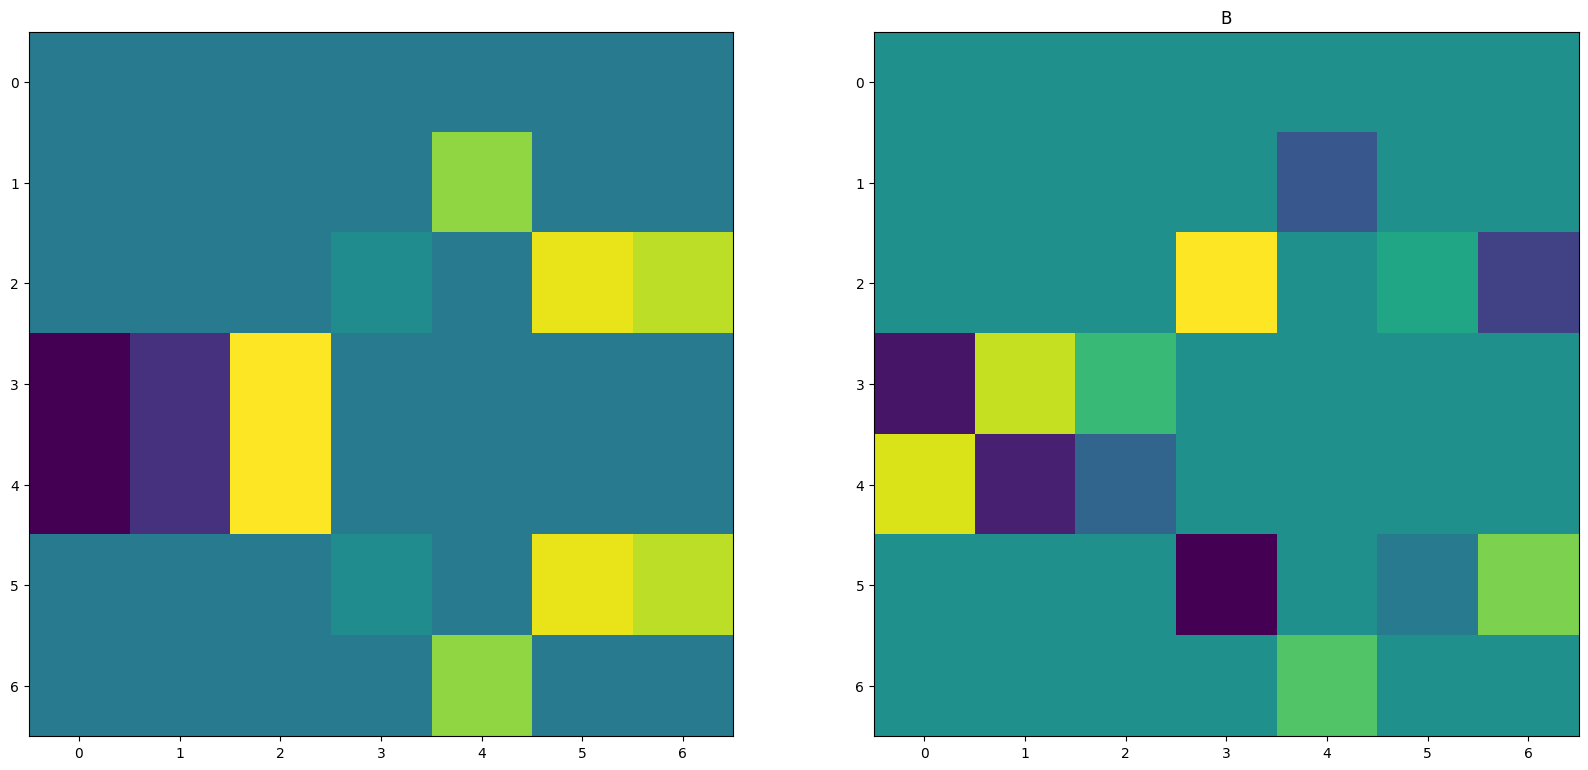

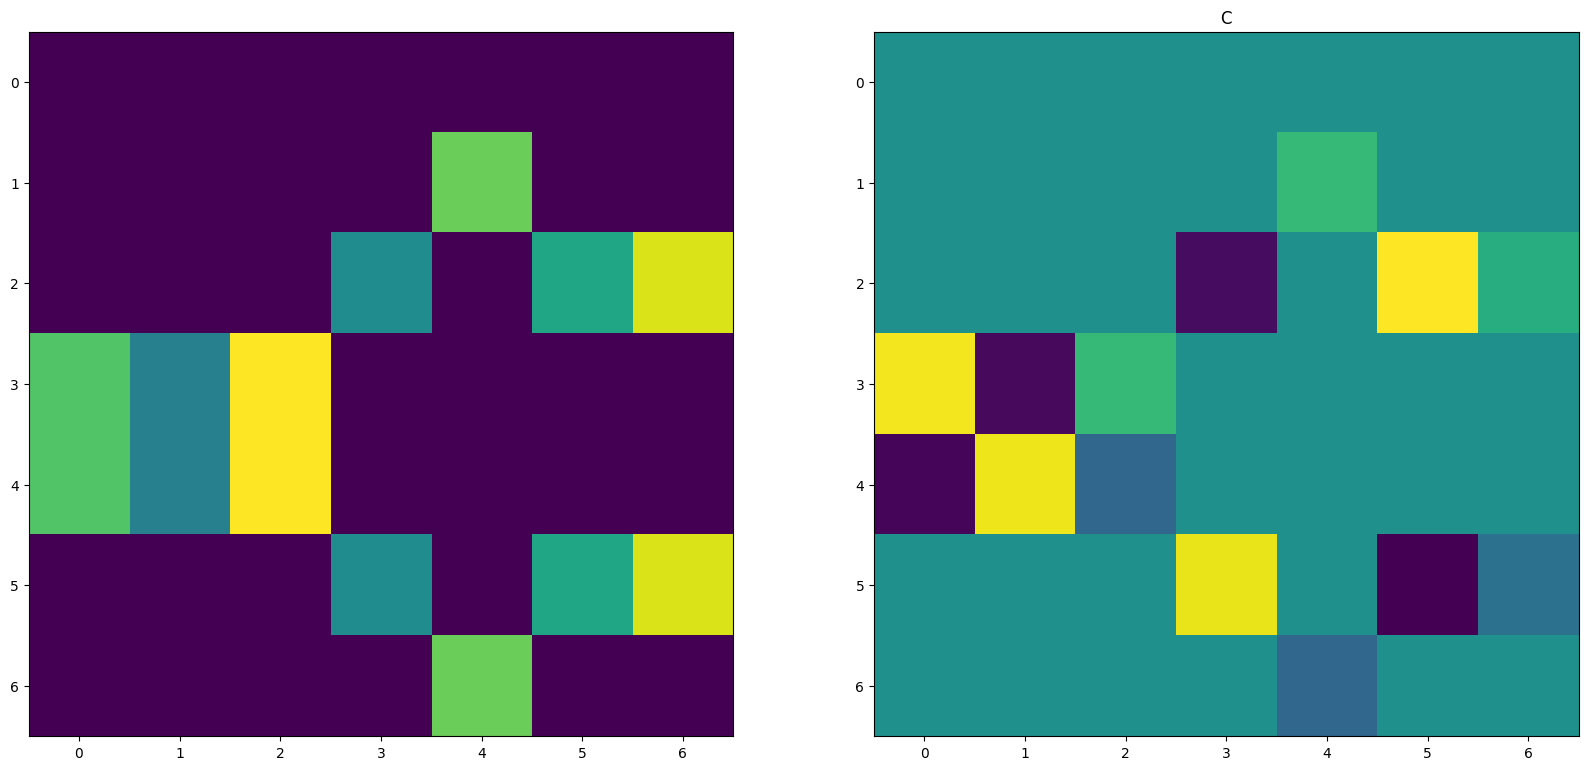

15 tensor(-4.5000) tensor(2.7001) tensor(2.6887) tensor(2.6964)


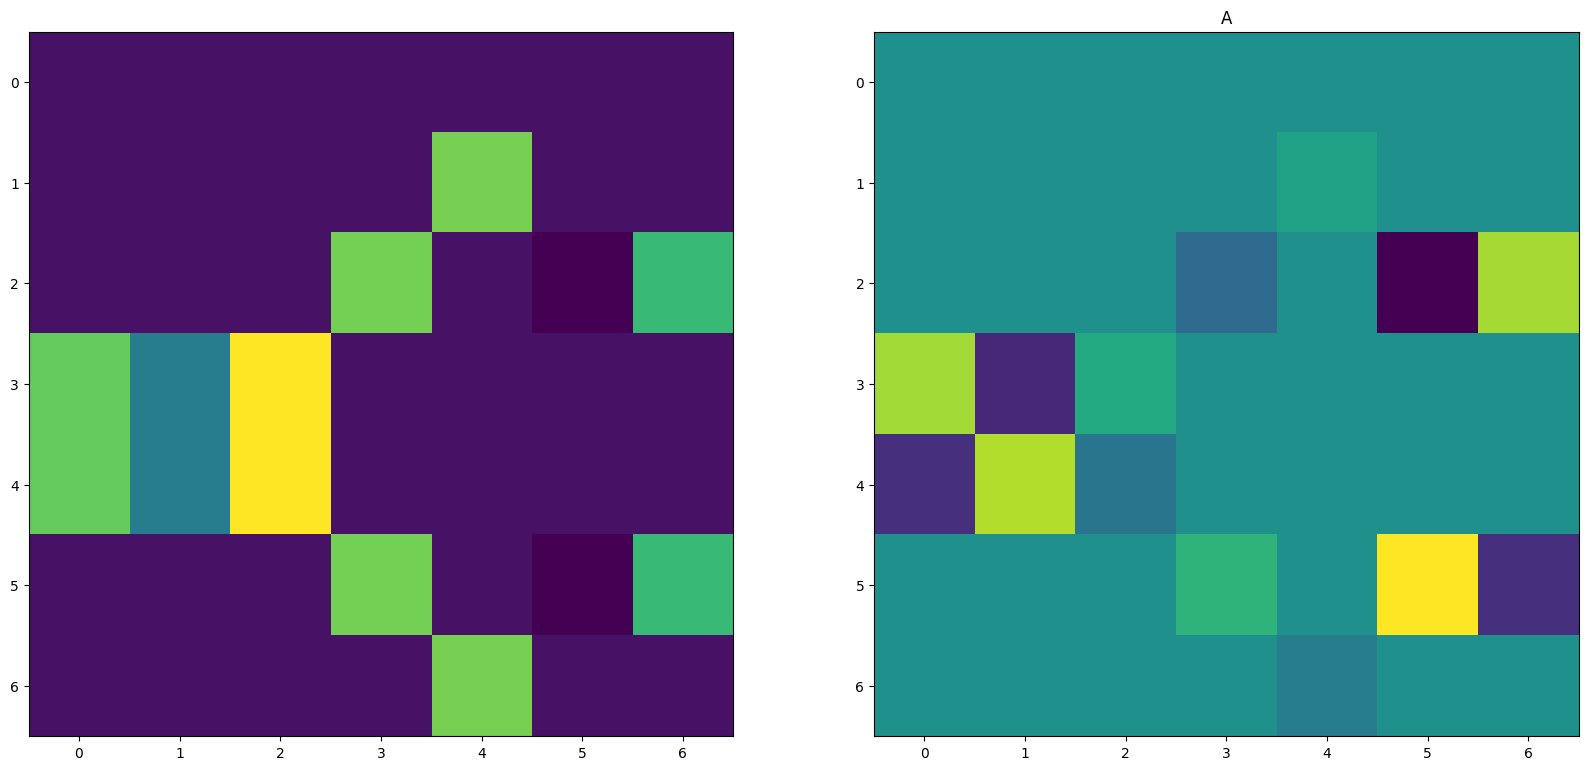

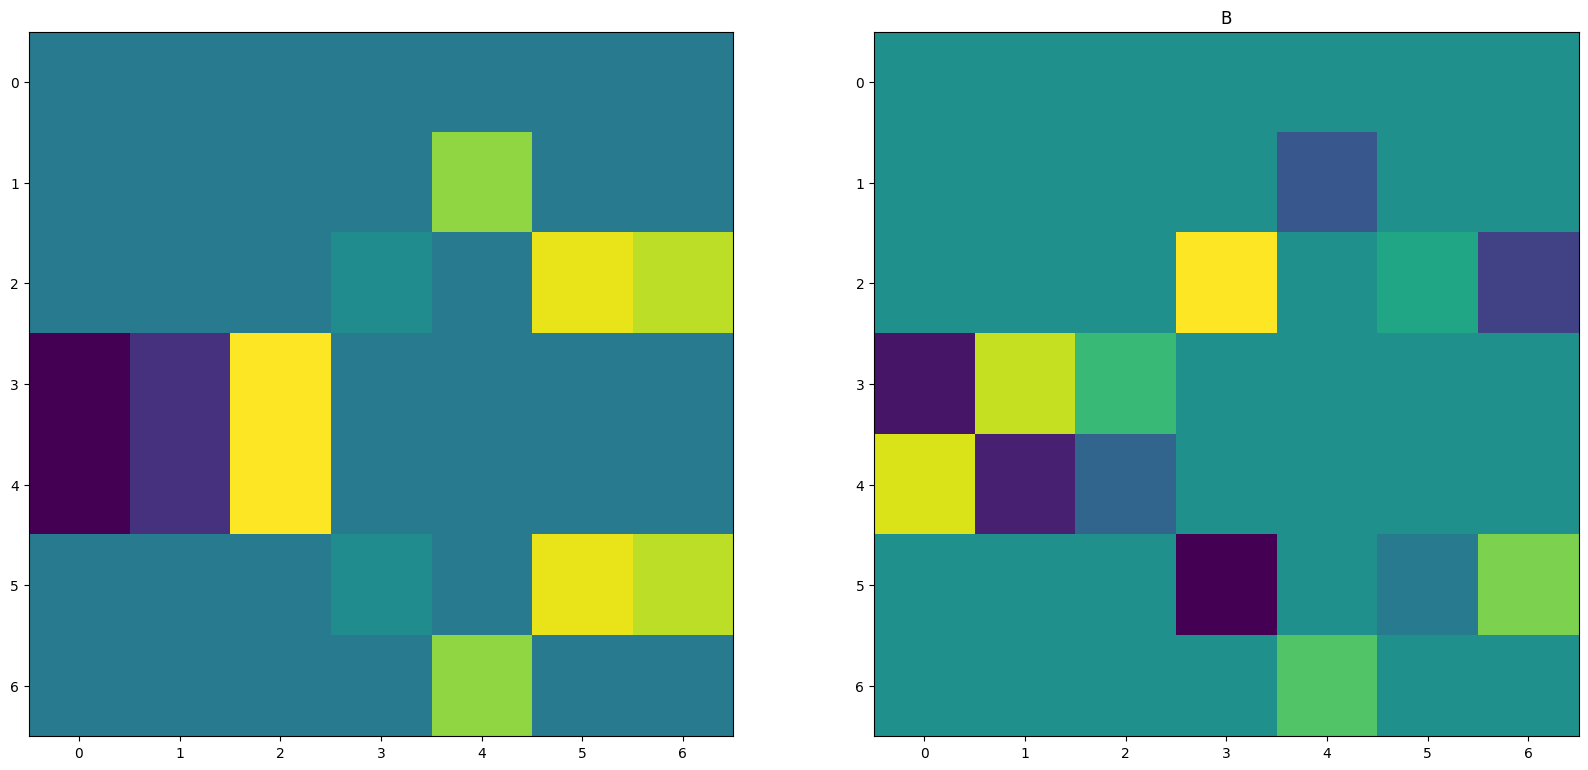

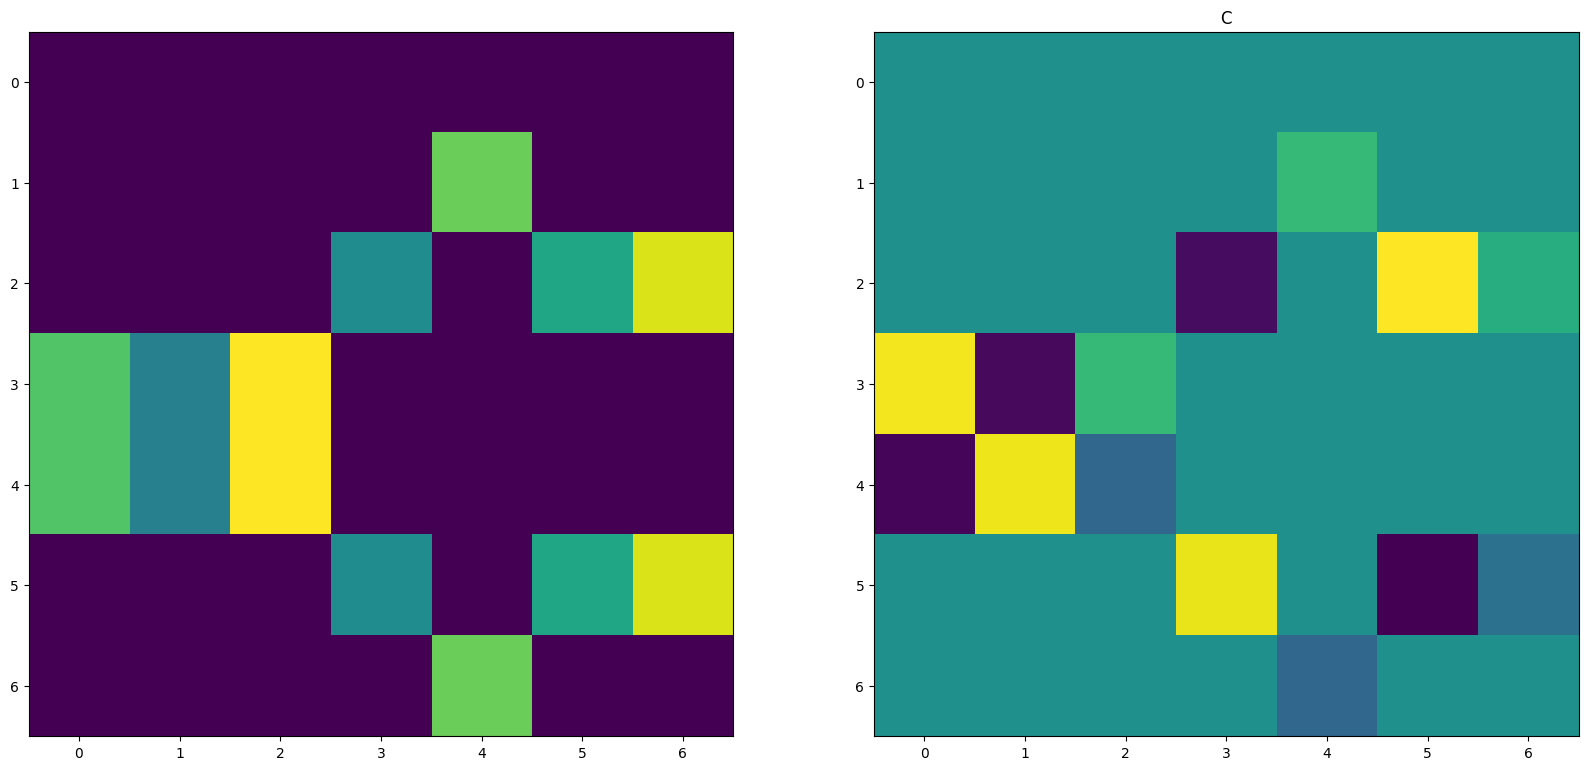

29 tensor(-4.5000) tensor(2.6997) tensor(2.6883) tensor(2.6960)


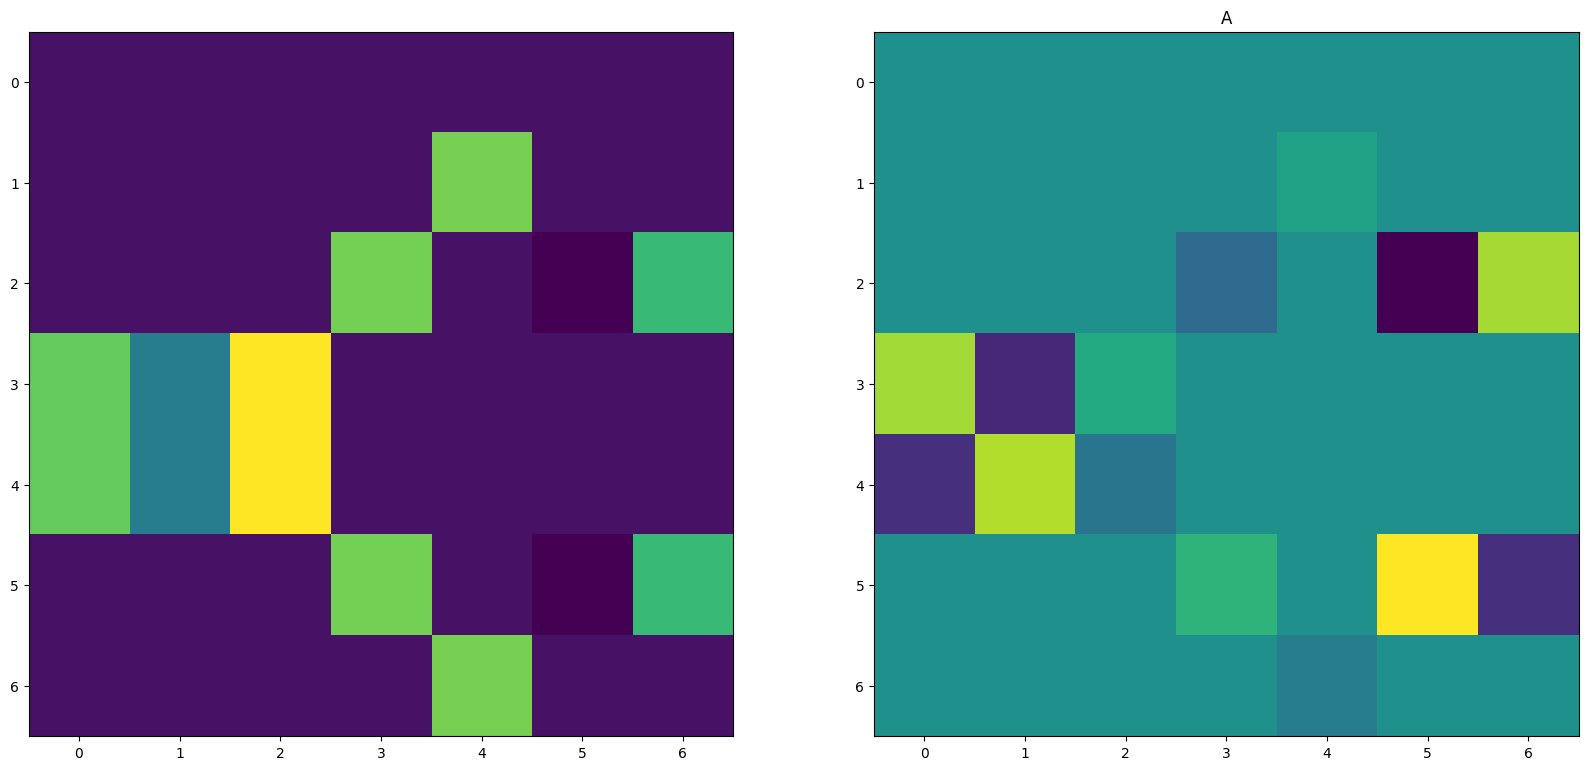

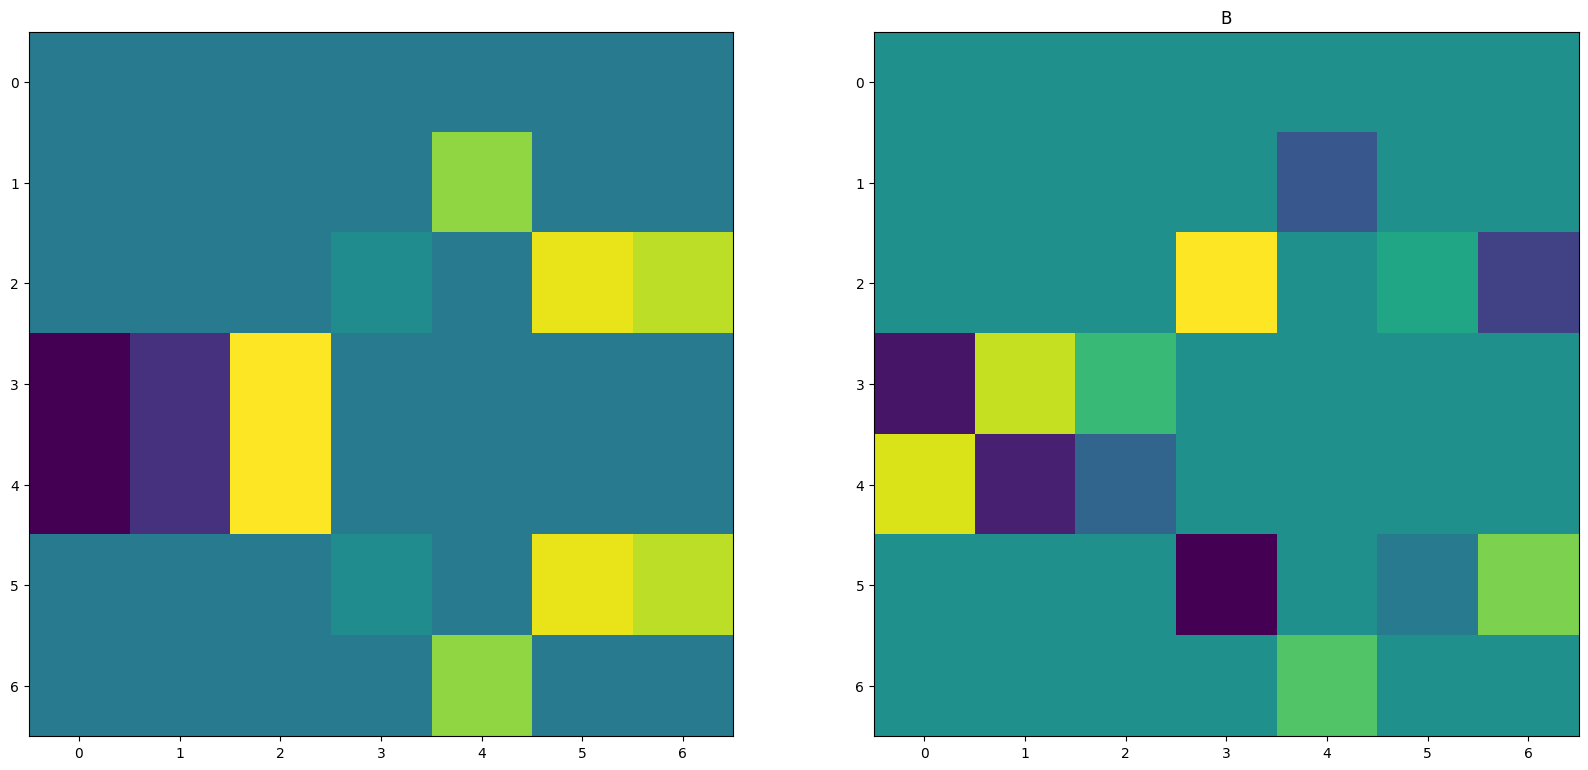

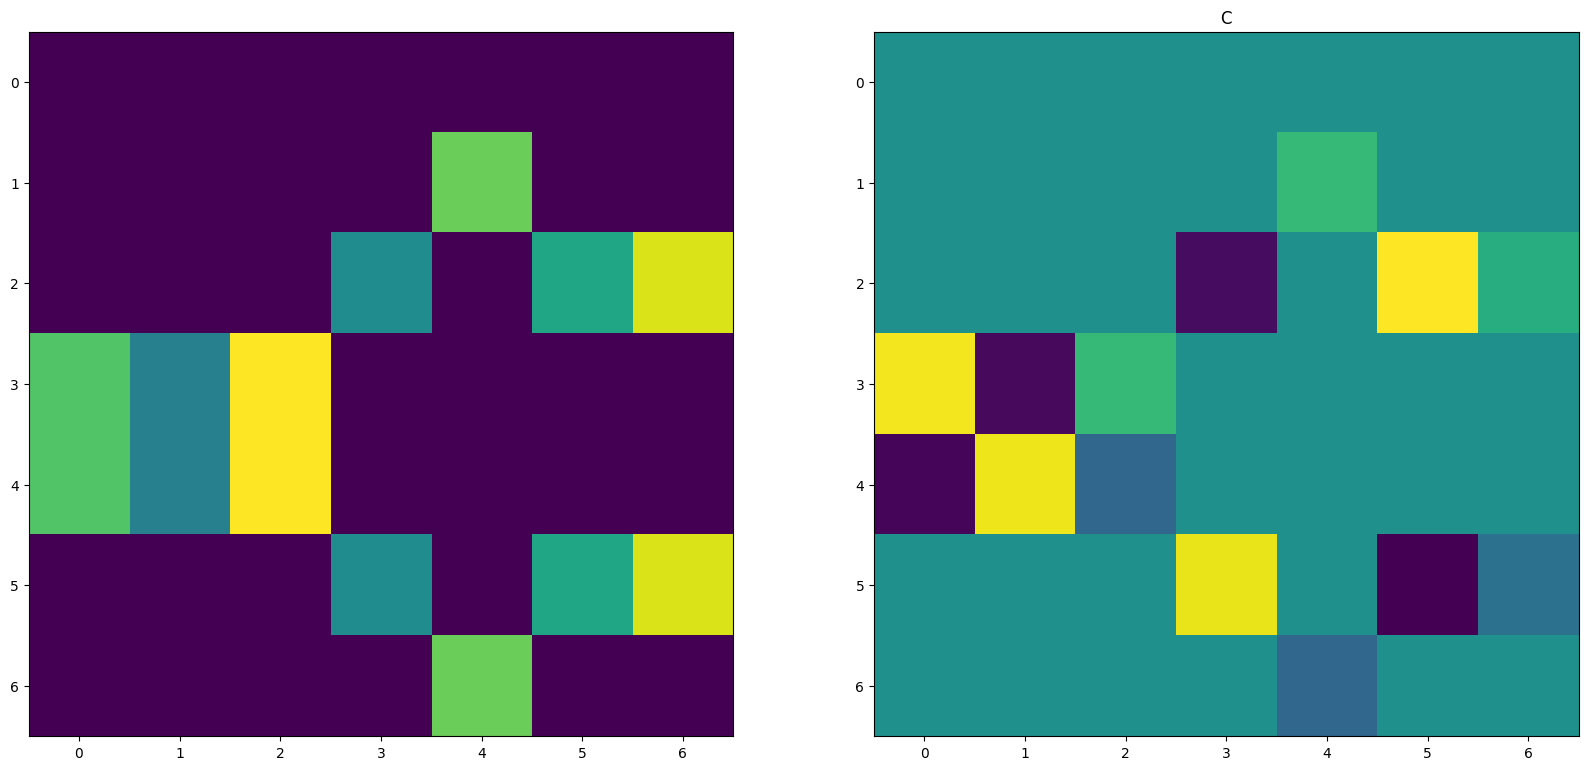

-1 tensor(-4.5000) tensor(2.6993) tensor(2.6880) tensor(2.6957)


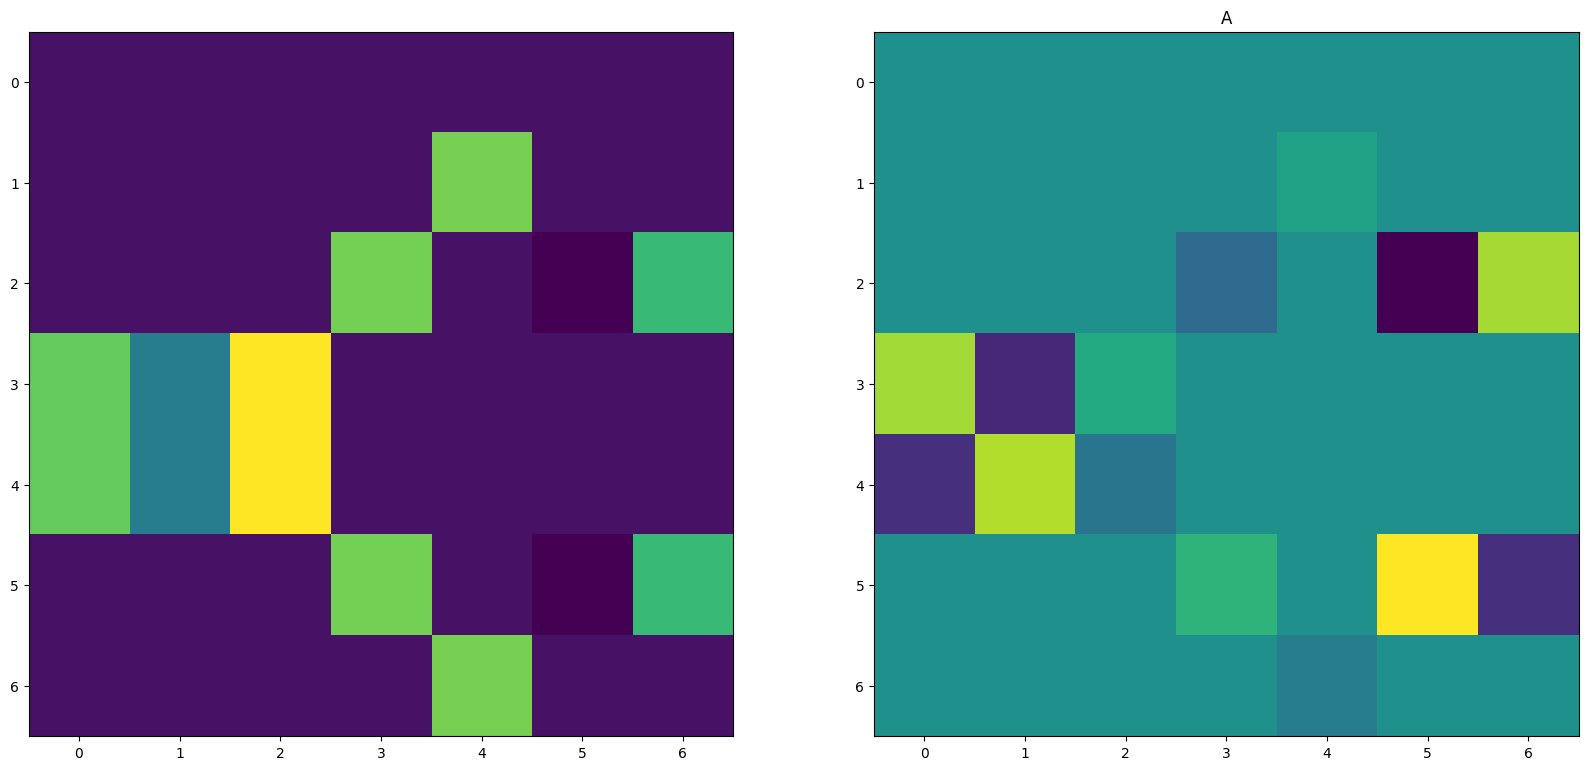

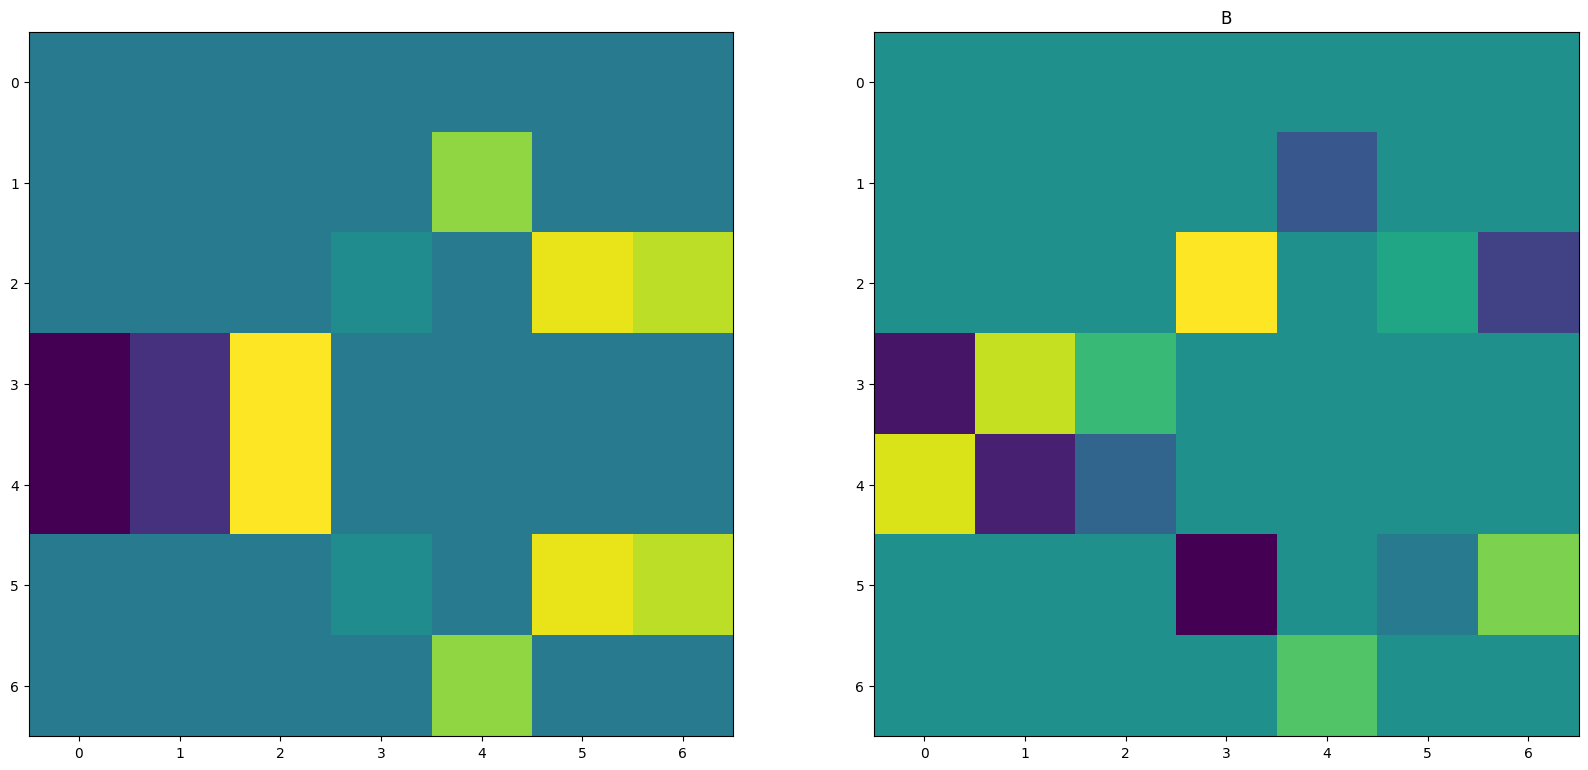

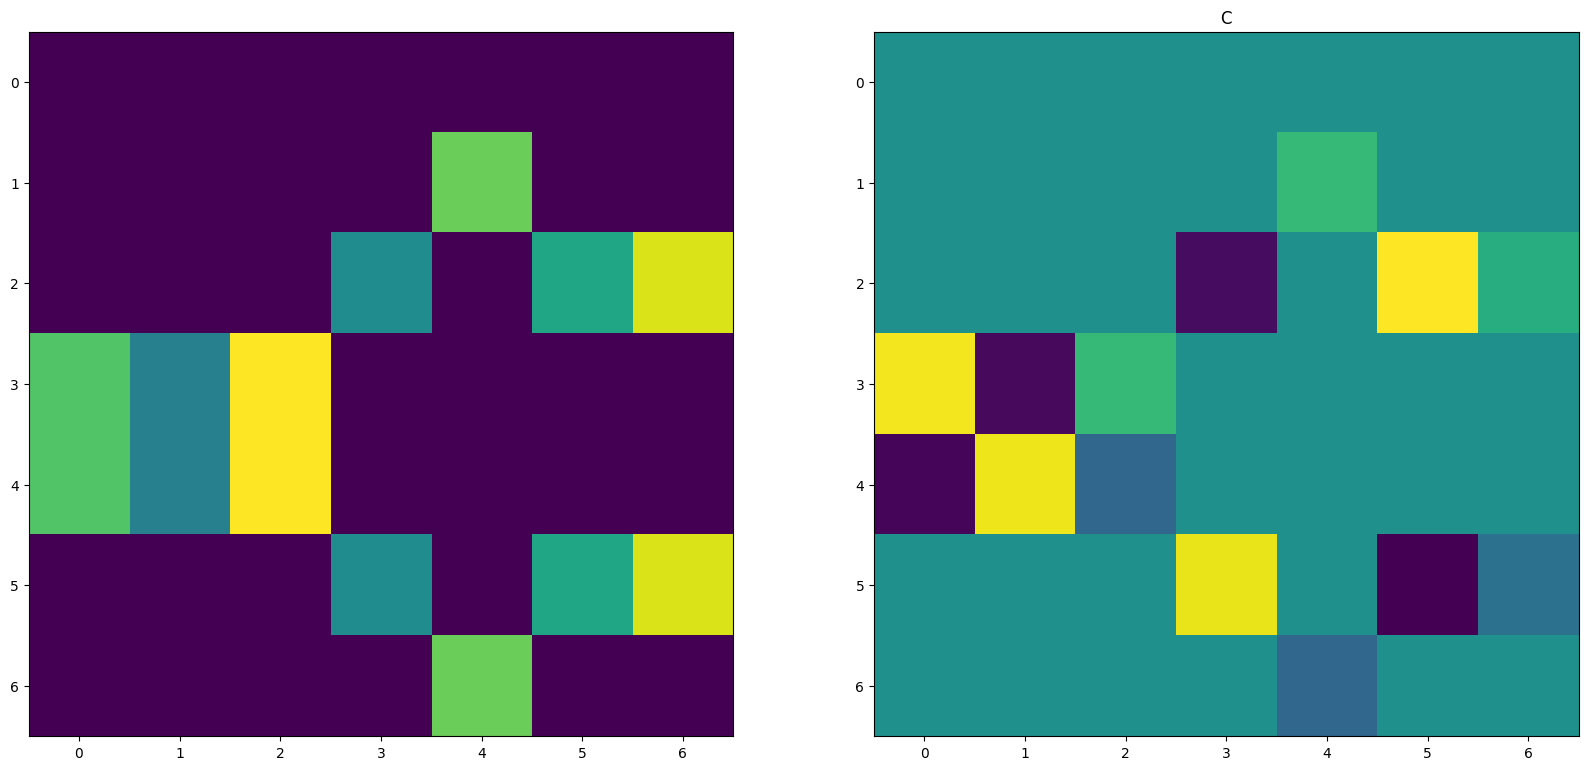

In [53]:
for t in [0, 8, 9, 10, 11, 12, 13, 14, 15, 29, -1]:
    print(t, losses[allts[t]].real, allA[t].norm(), allB[t].norm(), allC[t].norm())
    
    plt.figure(figsize=(20, 30))
    plot_complex(allA[t], "A")
    plt.figure(figsize=(20, 30))
    plot_complex(allB[t], "B")
    plt.figure(figsize=(20, 30))
    plot_complex(allC[t], "C")

(-6-4.768372718899627e-07j)


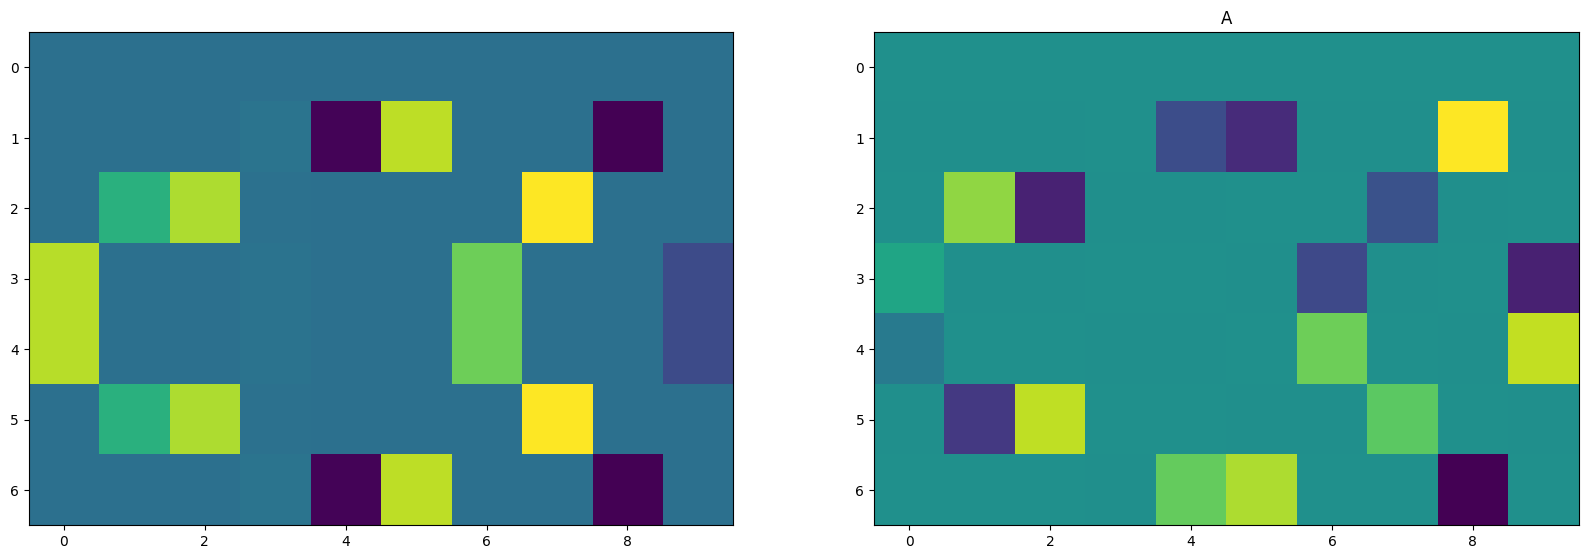

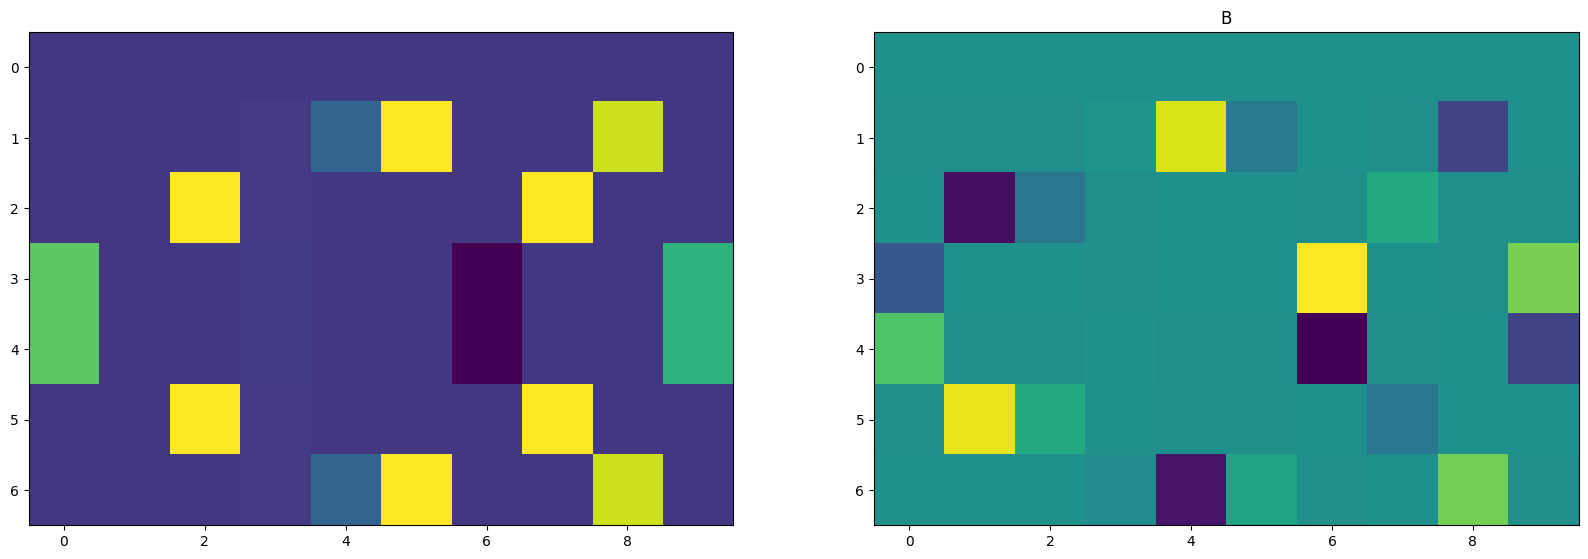

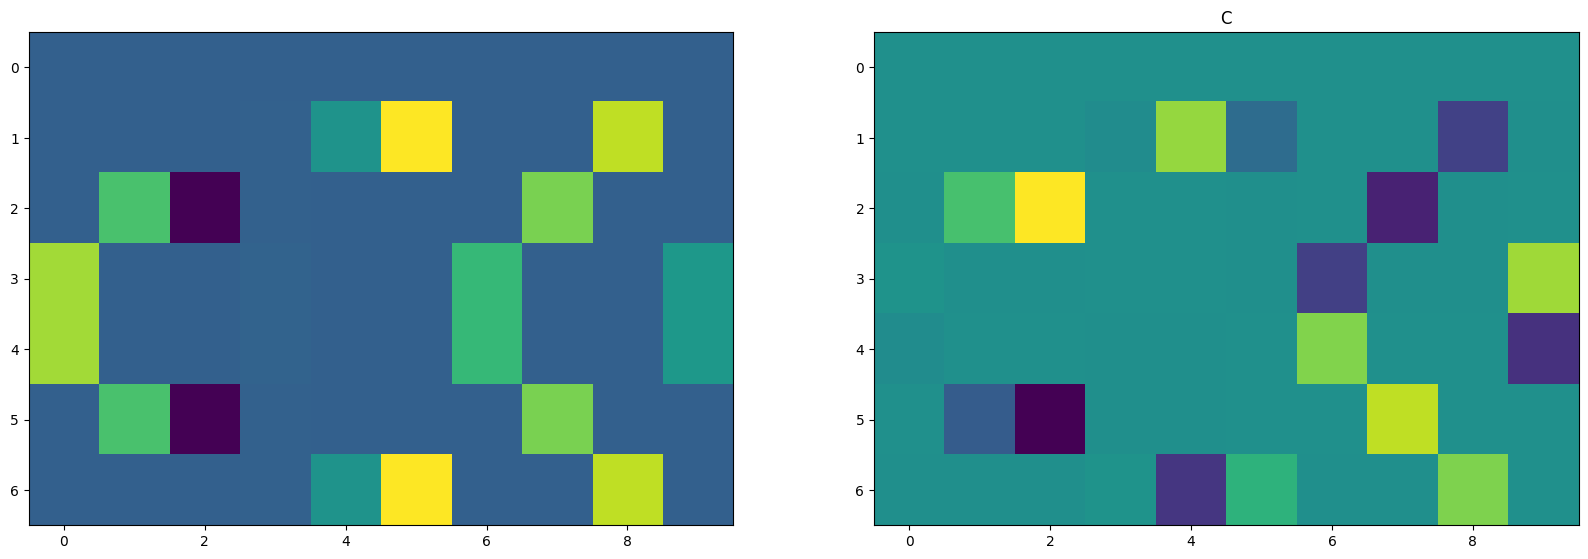

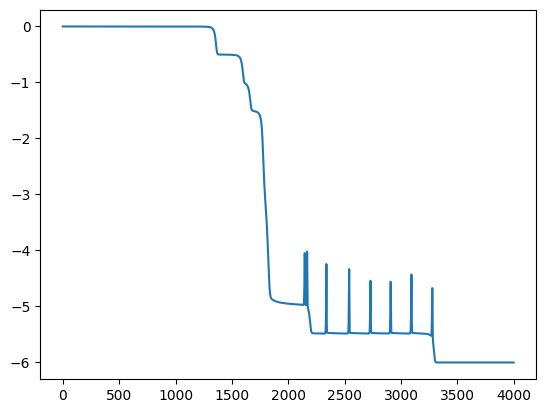

In [191]:
# Check diagonal and off-diagonal values

def check_constraints(A, B, C):
    diag_values = []
    off_diag_values = []

    values_a_diag = []
    values_a_off_diag = []
    values_b_diag = []
    values_b_off_diag = []

    diag_index = []
    off_diag_index = []

    for k1 in range(d):
        for k2 in range(d):
            for k3 in range(d):
                v = (A[k1, :] * B[k2, :] * C[k3, :]).sum()
                va = (A[k1, :] * A[k2, :] * C[k3, :]).sum()
                vb = (B[k1, :] * B[k2, :] * C[k3, :]).sum()

                if k1 == k2 == k3:
                    diag_values.append(v)
                    values_a_diag.append(va)
                    values_b_diag.append(vb)
                else:
                    off_diag_values.append(v)
                    values_a_off_diag.append(va)
                    values_b_off_diag.append(vb)

    diag_values = torch.stack(diag_values)
    off_diag_values = torch.stack(off_diag_values)

    va_diag_values = torch.stack(values_a_diag)
    va_off_diag_values = torch.stack(values_a_off_diag)

    vb_diag_values = torch.stack(values_b_diag)
    vb_off_diag_values = torch.stack(values_b_off_diag)

    print("ABC Off diagonal")
    print(off_diag_values.abs().max())
    print("ABC diagonal")
    print(diag_values)

    print("AAC Off diagonal")
    print(va_off_diag_values.abs().max())
    print("AAC diagonal")
    print(va_diag_values)

    print("BBC Off diagonal")
    print(vb_off_diag_values.abs().max())
    print("BBC diagonal")
    print(vb_diag_values)


    # check second terms
    AnormC = (A * A.conj()) @ C.t() 
    BnormC = (B * B.conj()) @ C.t() 

    print(AnormC.norm(), BnormC.norm())

ABC Off diagonal
tensor(0.0019)
ABC diagonal
tensor([0.0000+0.0000e+00j, 0.0742+1.9060e-05j, 0.0703-3.3186e-05j,
        0.0716+1.6122e-05j, 0.0716-1.6122e-05j, 0.0703+3.3186e-05j,
        0.0742-1.9060e-05j])
AAC Off diagonal
tensor(0.0430)
AAC diagonal
tensor([ 0.0000e+00+0.0000e+00j,  3.4615e-05+4.6181e-05j,
        -1.8958e-05-2.5999e-05j, -1.3115e-04-3.6202e-04j,
        -1.3115e-04+3.6202e-04j, -1.8958e-05+2.5999e-05j,
         3.4615e-05-4.6181e-05j])
BBC Off diagonal
tensor(0.0464)
BBC diagonal
tensor([0.0000e+00+0.0000e+00j, 4.3830e-05+1.5824e-04j, 5.6690e-05+3.2088e-05j,
        1.0393e-04+3.2404e-04j, 1.0393e-04-3.2404e-04j, 5.6690e-05-3.2088e-05j,
        4.3830e-05-1.5824e-04j])
tensor(0.1097) tensor(0.1144)


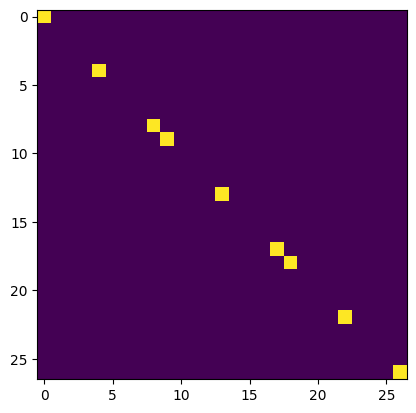

In [47]:
# Check the behavior of I(k1=k1')I(k2=k2=k3=k3), versus I(k1=k1')I(k2=k2')I(k3=k3') 
d = 3

M1 = torch.zeros(d, d, d, d, d, d)

for i in range(d):
    for j in range(d):
        M1[i, j, j, i, j, j] = 1
        
M1 = M1.view(d*d*d,d*d*d)

plt.imshow(M1)